In [1]:
from setup import *

In [2]:
config = load_config()
print(config['HCP_DIR'])
subjects = range(config["N_SUBJECTS"])

../data/


In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = config["N_SUBJECTS"]

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = config["N_PARCELS"]

# The acquisition parameters for all tasks were identical
TR = config["TR"]  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = config["HEMIS"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = config["N_RUNS_REST"]
N_RUNS_TASK = config["N_RUNS_TASK"]

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = config["BOLD_NAMES"]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

DATA_FILES = config["DATA_FILES"]

HCP_DIR = config["HCP_DIR"]

## **Helper Functions**

In [5]:
def get_image_ids(
    name, 
    bold_names
):
    """Get the 1-based image indices for runs in a given experiment.
    
    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
      bold_names (list[str]) : List of each task acquisition
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files
    
    """
    run_ids = [
             i for i, code in enumerate(bold_names, 1) if name.upper() in code
             ]
    if not run_ids:
        raise ValueError(f"Found no data for '{name}'")
    return run_ids


def load_timeseries(
    subject,
    name,
    data_dir,
    bold_names,
    runs=None,
    concat=True,
    remove_mean=True
):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    data_dir (str) : data directory
    bold_names (list[str]) : List of each task acquisition
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name, bold_names)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      data_dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(
    subject,
    bold_run,
    data_dir,
    remove_mean=True
):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    data_dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(data_dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(
    subject, 
    name, 
    bold_names,
    condition, 
    data_dir, 
):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    bold_names (list[str]) : List of each task acquisition
    condition (str) : Name of condition
    data_dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name, bold_names):
    task_key = bold_names[id - 1]
    ev_file = os.path.join(data_dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

In [6]:
def condition_frames(run_evs, skip=0):
    """Identify timepoints corresponding to a given condition in each run.
    Args:
        run_evs (list of dicts) : Onset and duration of the event, per run
        skip (int) : Ignore this many frames at the start of each trial, to account
          for hemodynamic lag
    Returns:
        frames_list (list of 1D arrays): Flat arrays of frame indices, per run
    """
    frames_list = []
    for ev in run_evs:
        # Check if the event dictionary is empty
        if not ev:
            continue  # Skip this event and move to the next one

        # Check if 'onset' and 'duration' keys exist
        if 'onset' not in ev or 'duration' not in ev:
            continue  # Skip this event if it doesn't have required keys

        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]
        frames_list.append(np.concatenate(frames))
    
    return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

## Step 0 : Preparing Connectivity and Behavioral Inputs

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')
    Subject  0BK_ACC  0BK_MEDIAN_RT  0BK_D_PRIME   2BK_ACC  2BK_MEDIAN_RT  \
0         0   1.0000       852.2500     4.652696  0.921875      1054.4375   
1         1   1.0000       529.0625     4.652696  0.968750       865.5625   
2         2   0.9875       584.1250     3.860468  0.921875       940.5625   
3         3   0.9750       731.7500     3.687995  0.703125       798.0000   
4         4   0.6750       852.8125     0.579132  0.765625       864.0625   
5         5   1.0000       699.5000     4.652696  0.906250       996.0000   
6         6   0.9500       697.3750     3.013081  0.85

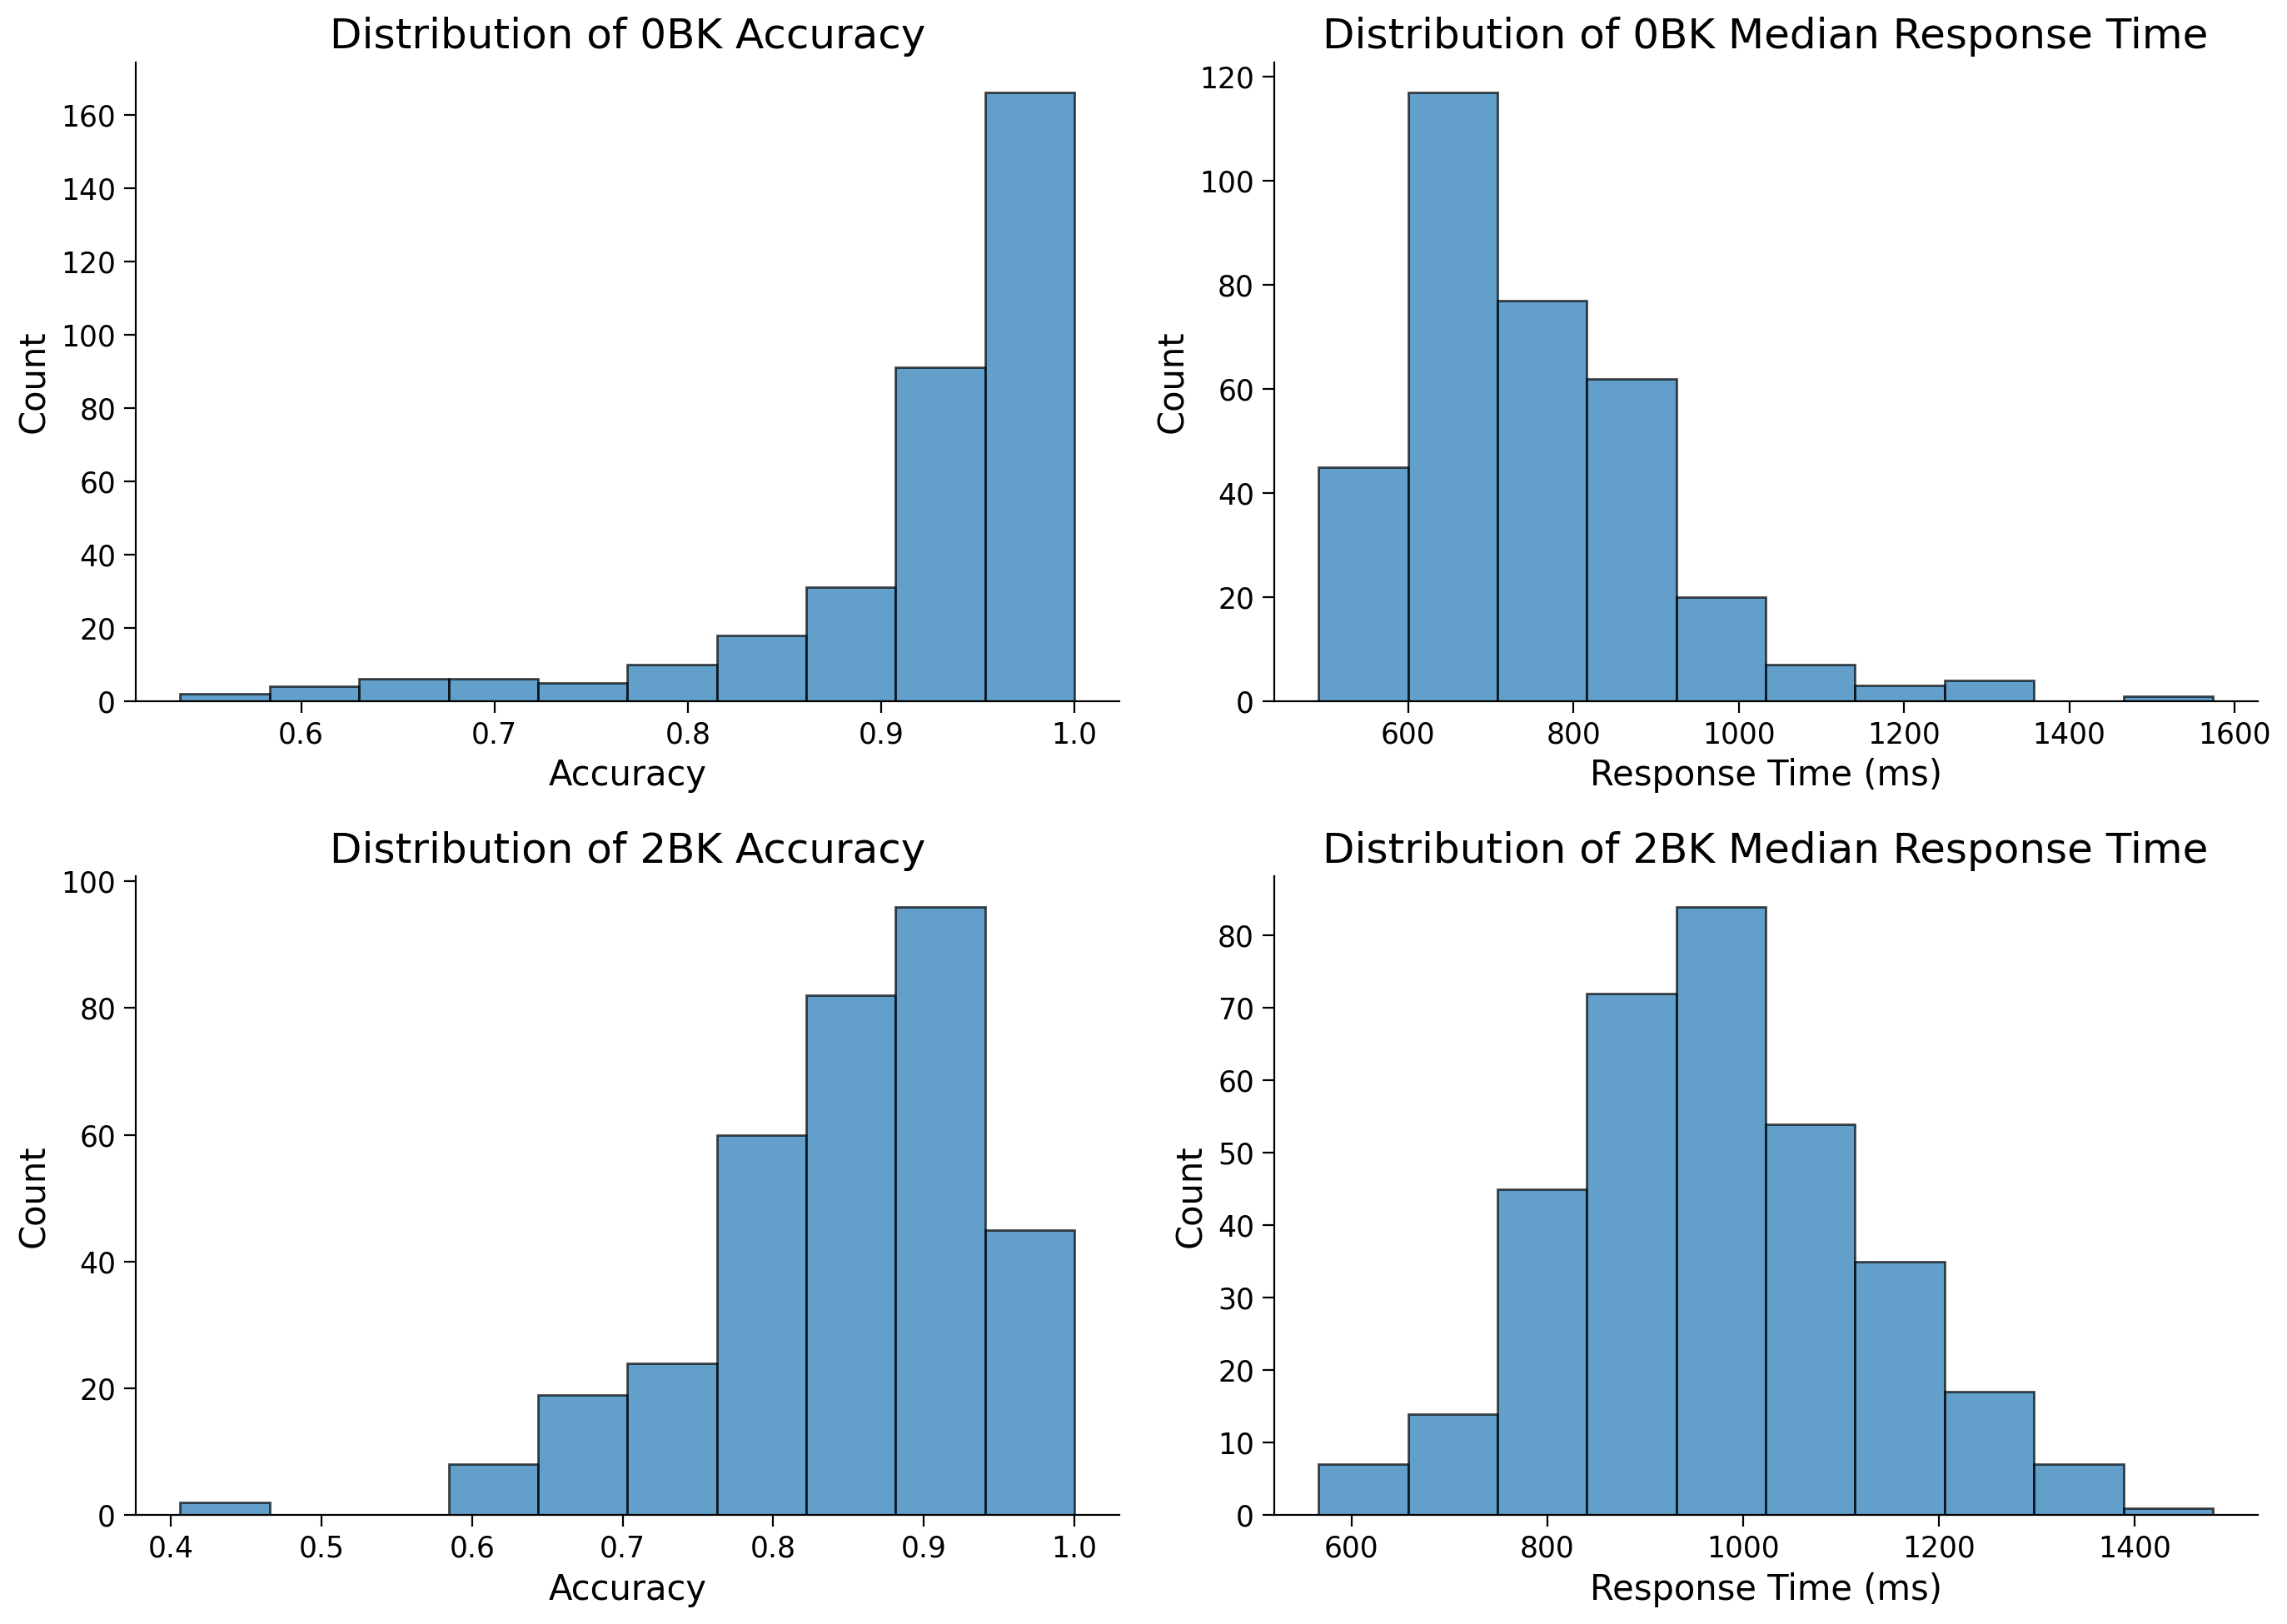

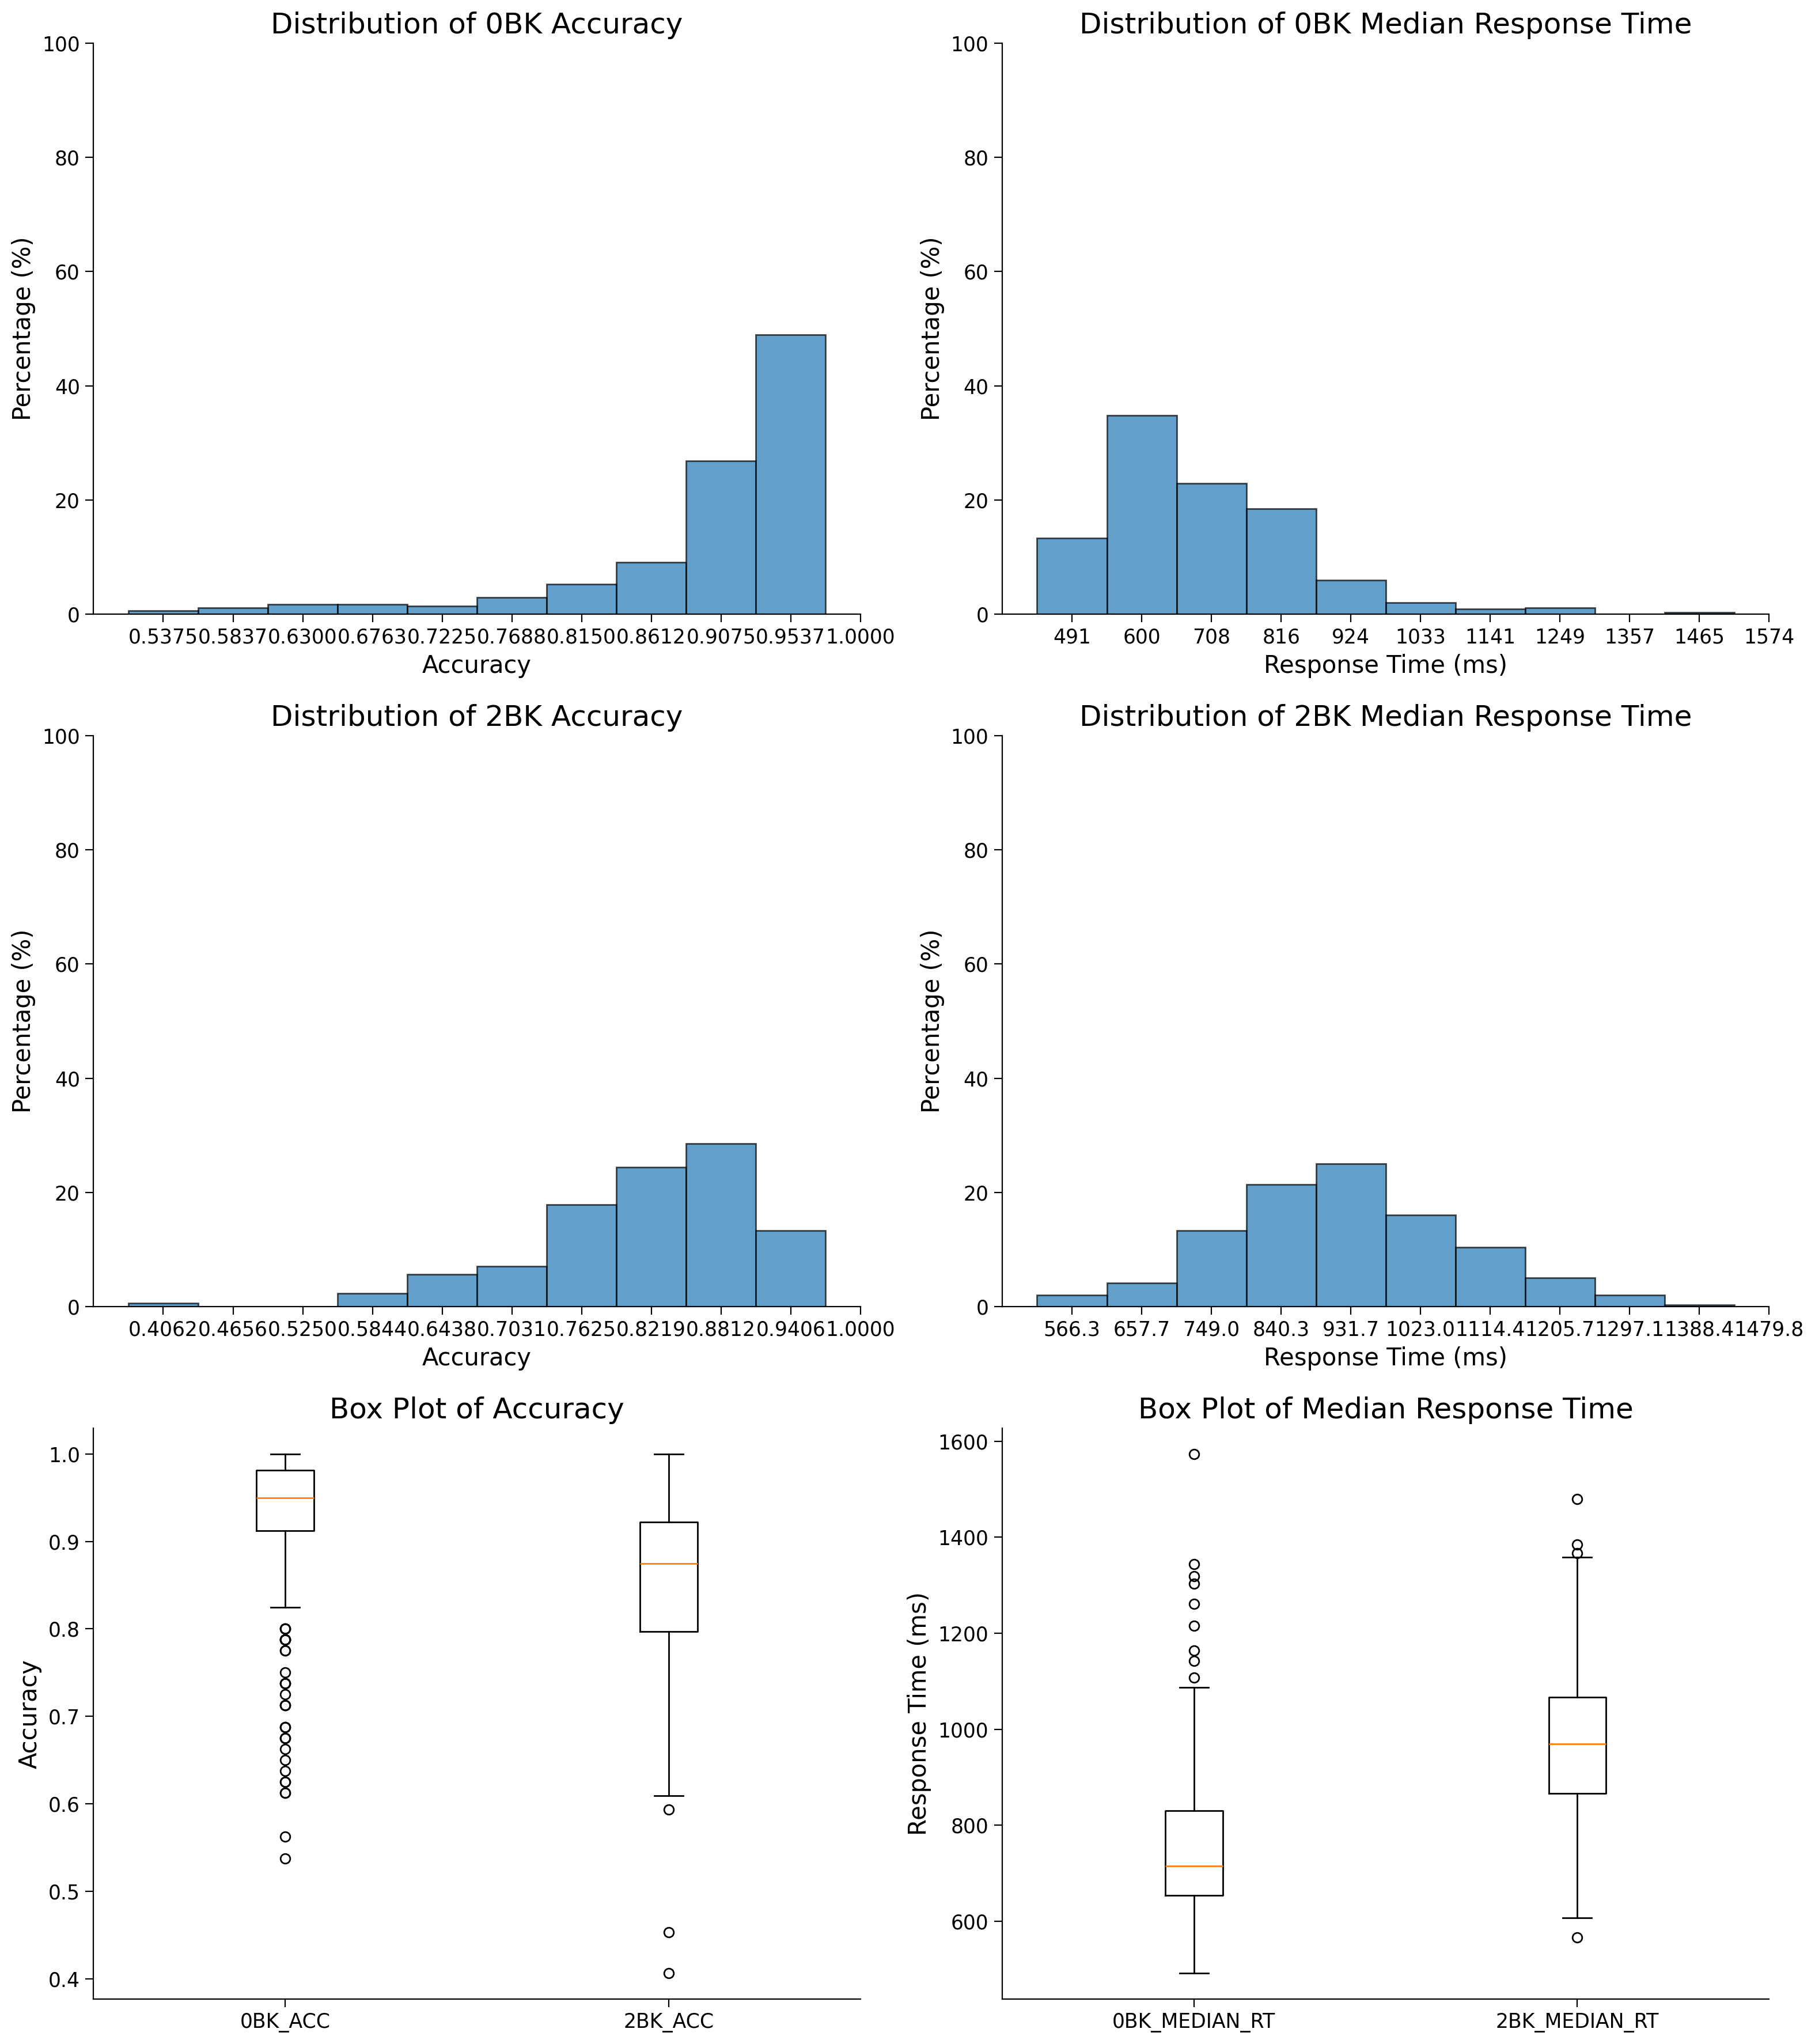

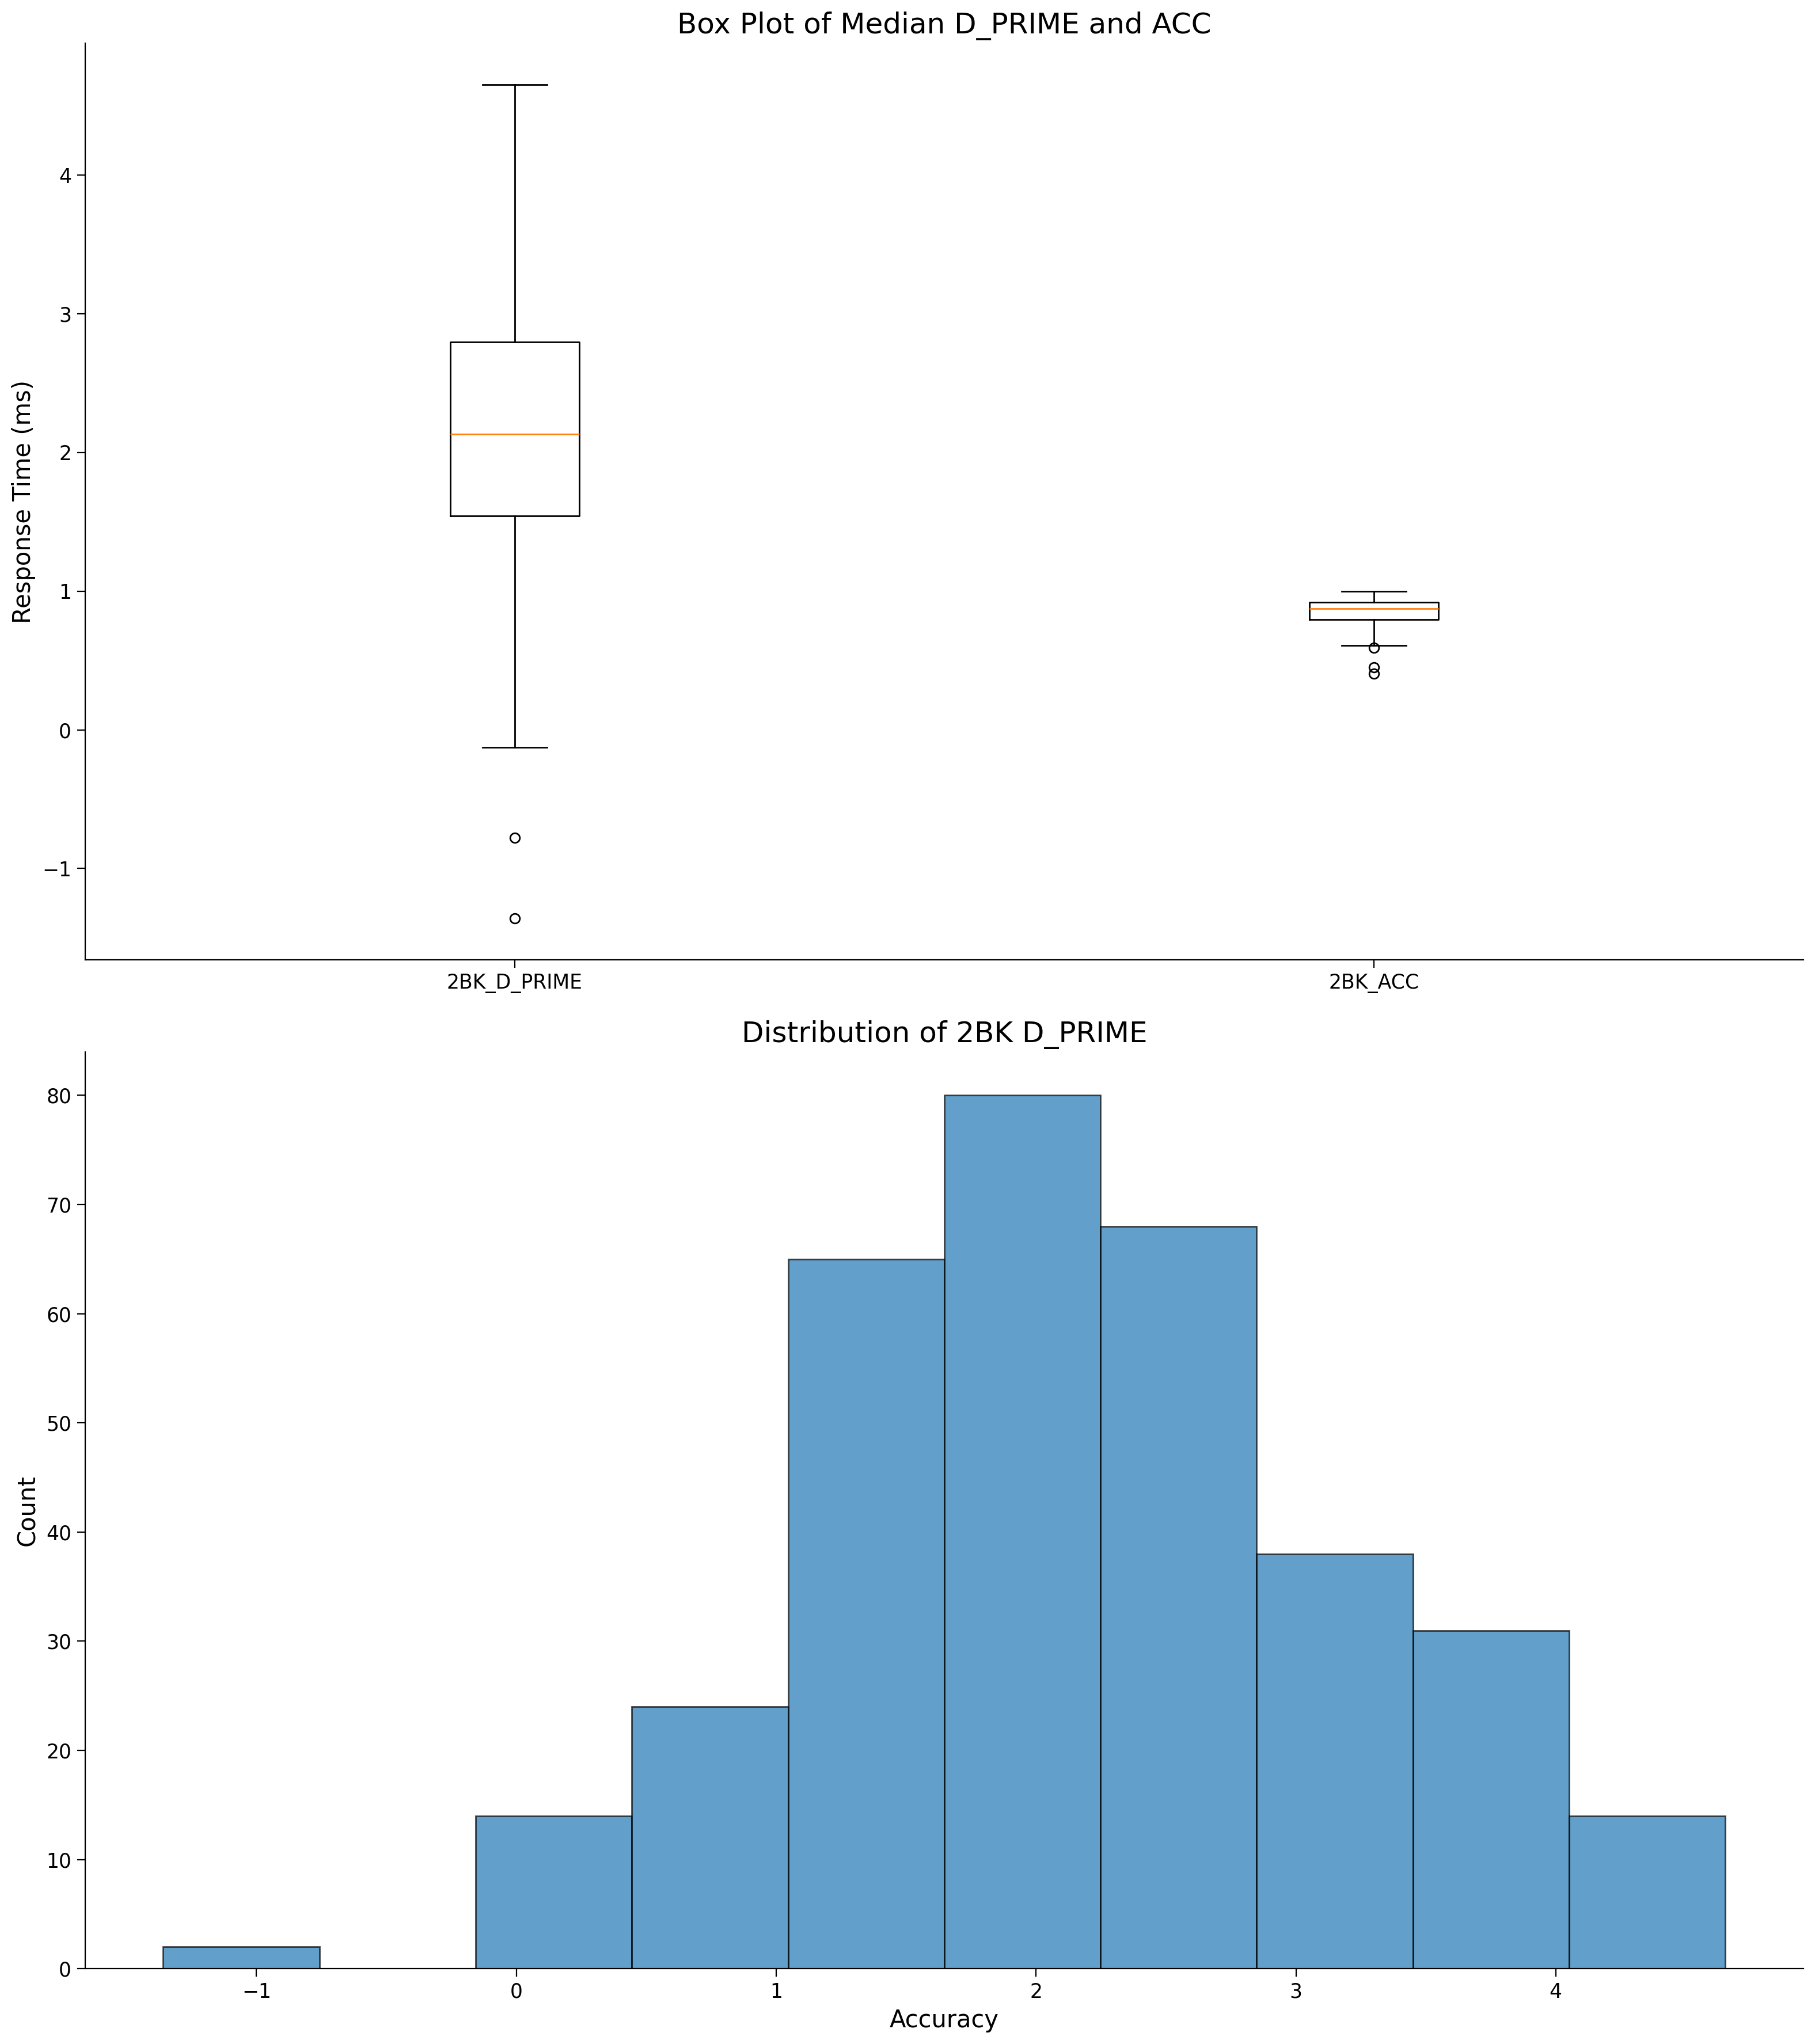

In [7]:
%run ./memory_performance.ipynb

In [8]:
def calculate_fc(
    timeseries,
    indices
):
    timeseries = timeseries[indices, :]
    correlation_matrix = np.corrcoef(timeseries)
    return correlation_matrix


def plot_connectivity_matrix(matrix, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.show()

In [9]:
timeseries_task = []
corr_matrices = []
frames_2back = []

for subject in subjects:
    frames_cor = []
    #### Get the LR timeseries for the working memory task
    ####
    timeseries = load_timeseries(
        subject=subject,
        name="wm_lr",
        bold_names=BOLD_NAMES,
        data_dir=HCP_DIR + "hcp_task"
    )
    # Get the frames for 2-back correct and error trials
    evs_cor = load_evs(
        subject=subject,
        name="wm_lr",
        bold_names=BOLD_NAMES,
        condition="2bk_cor",
        data_dir=HCP_DIR + "hcp_task"
    )
    evs_err = load_evs(
        subject=subject,
        name="wm_lr",
        bold_names=BOLD_NAMES,
        condition="2bk_err",
        data_dir=HCP_DIR + "hcp_task"
    )
    
    frames_cor = condition_frames(evs_cor)
    frames_err = condition_frames(evs_err)

    if len(frames_err) > 0:
        frames_2back = sorted(np.concatenate([frames_cor, frames_err], axis=1)[0])
    else:
        frames_2back = sorted(frames_cor[0])
    timeseries_2back_lr = timeseries[:, frames_2back]

    #### Get the RL timeseries for the working memory task
    ####
    timeseries = load_timeseries(
        subject=subject,
        name="wm_rl",
        bold_names=BOLD_NAMES,
        data_dir=HCP_DIR + "hcp_task"
    )
    # Get the frames for 2-back correct and error trials
    evs_cor = load_evs(
        subject=subject,
        name="wm_rl",
        bold_names=BOLD_NAMES,
        condition="2bk_cor",
        data_dir=HCP_DIR + "hcp_task"
    )
    evs_err = load_evs(
        subject=subject,
        name="wm_rl",
        bold_names=BOLD_NAMES,
        condition="2bk_err",
        data_dir=HCP_DIR + "hcp_task"
    )
    
    frames_cor = condition_frames(evs_cor)
    frames_err = condition_frames(evs_err)

    if len(frames_err) > 0:
        frames_2back = sorted(np.concatenate([frames_cor, frames_err], axis=1)[0])
    else:
        frames_2back = sorted(frames_cor[0])
    timeseries_2back_rl = timeseries[:, frames_2back]
    
    # Combine correct and error frames
    timeseries_2back = np.mean([timeseries_2back_rl], axis=0)

    #### Compute connectivity matrix and append to list
    ####
    fc = calculate_fc(timeseries_2back, np.arange(0, 360))
    corr_matrices.append(fc)

In [10]:
def transform_fc_matrices(fc_matrix_list):
    """
    Transform a list of FC matrices into the 3D array format expected by the CPM implementation.
    
    Parameters:
    fc_matrix_list (list): List of 2D numpy arrays, each representing a subject's FC matrix.
    
    Returns:
    numpy.ndarray: 3D array with shape (n_nodes, n_nodes, n_subjects)
    """
    # Check if all matrices have the same shape
    shapes = set(matrix.shape for matrix in fc_matrix_list)
    if len(shapes) != 1:
        raise ValueError("All matrices must have the same shape")
    
    # Get the number of nodes and subjects
    n_nodes = fc_matrix_list[0].shape[0]
    n_subjects = len(fc_matrix_list)
    
    # Create the 3D array
    fc_array_3d = np.stack(fc_matrix_list, axis=2)
    
    print(f"Transformed FC matrices into 3D array with shape: {fc_array_3d.shape}")
    return fc_array_3d

## Step 1: Connectivity Matrices and Behavioral Measures

In [11]:
fc_matrices = transform_fc_matrices(corr_matrices)
print(fc_matrices.shape)
print(memory_performance_metrics.shape)

Transformed FC matrices into 3D array with shape: (360, 360, 339)
(360, 360, 339)
(339, 7)


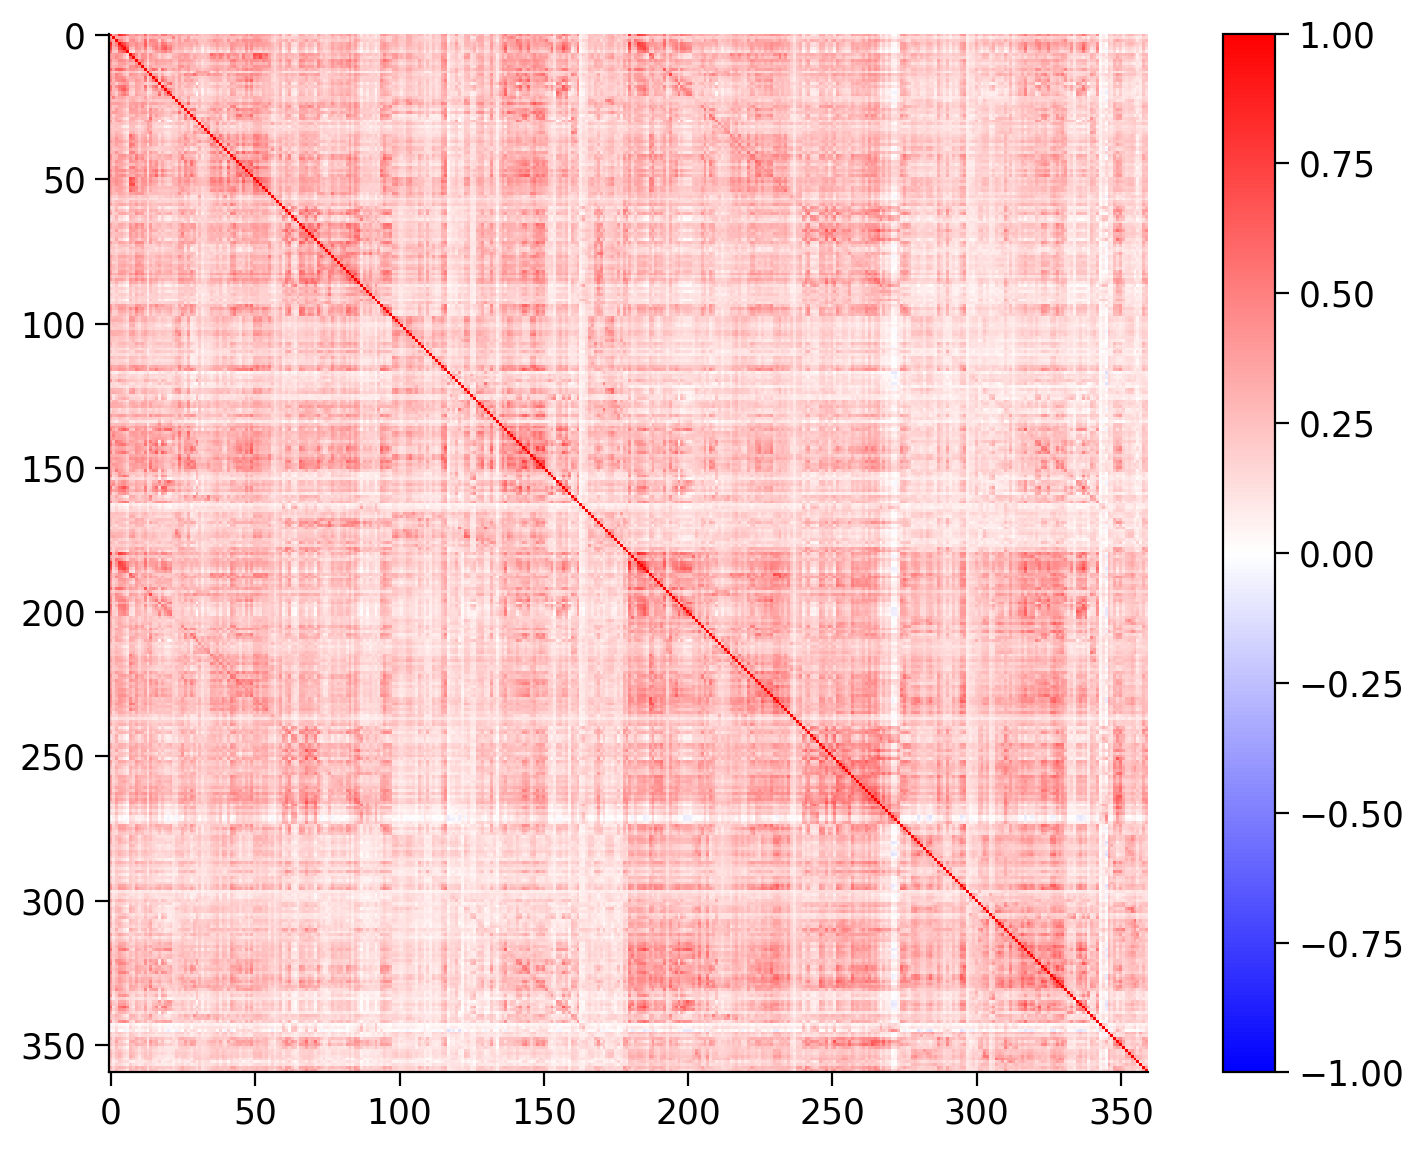

In [12]:
group_fc = fc_matrices.mean(axis=2)

plt.figure()
plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [90]:
num_subjects = fc_matrices.shape[2]
flattened_connectivity = fc_matrices.reshape(360*360, num_subjects).T
connectivity_df = pd.DataFrame(flattened_connectivity)
connectivity_df['Subject'] = memory_performance_metrics['Subject']

# Merge connectivity features with memory performance metrics using the subject ID
merged_df = pd.merge(memory_performance_metrics, connectivity_df, on='Subject')

# Features (X) are the connectivity features
X = merged_df.drop(columns=['Subject', '0BK_ACC', '0BK_MEDIAN_RT', '0BK_D_PRIME', '2BK_ACC', '2BK_MEDIAN_RT', '2BK_D_PRIME']).values
# Target variable (y) is 0BK_ACC
y = merged_df['2BK_D_PRIME'].values
not_nan_indices = ~np.isnan(y)
X = X[not_nan_indices]
y = y[not_nan_indices]
print(X.shape)
print(y.shape)

(336, 129600)
(336,)


## Step 2: Correlat Connectivity and Behavior
## Step 3: Selecting Most Significant Edges
## Step 4: Sum Selected Edges

In [91]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )
dtype = [('name', 'U16'), ('network', 'U16'), ('myelin', 'f4')]
region_array = np.array(list(zip(region_info['name'], region_info['network'], region_info['myelin'])), dtype=dtype)
network_mapping = ['Frontopariet', 'Default', 'Visual1', 'Visual2', 'Somatomotor', 'Dorsal-atten', 'Ventral-Mult', 'Orbito-Affec']

def get_network_index(region_name):
    for idx, network in enumerate(network_mapping):
        if region_name == network:
            return idx
    return -1  # If not found

In [103]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
def select_significant_edges(X, y, p_threshold=0.01):
        num_edges = X.shape[1]
        positive_significant_edges = np.zeros((num_edges, len(network_mapping)), dtype=bool)
        negative_significant_edges = np.zeros((num_edges, len(network_mapping)), dtype=bool)
        
        for edge in range(num_edges):
            r, p = pearsonr(X[:, edge], y)
            # r, p = spearmanr(X[:, edge], y)
            if p < p_threshold:
                fisher_z = np.arctanh(r)
                node1, node2 = edge // len(region_info['network']), edge % len(region_info['network'])
                network1 = get_network_index(region_info['network'][node1])
                network2 = get_network_index(region_info['network'][node2])
                if network1 != -1:
                    if fisher_z > 0:
                        positive_significant_edges[edge, network1] = True
                    if fisher_z < 0:
                        negative_significant_edges[edge, network1] = True
                if network2 != -1:
                    if fisher_z > 0:
                        positive_significant_edges[edge, network2] = True
                    if fisher_z < 0:
                        negative_significant_edges[edge, network2] = True
        
        return positive_significant_edges, negative_significant_edges
    
def create_summary_features(X, positive_significant_edges, negative_significant_edges):
    num_subjects = X.shape[0]
    num_networks = positive_significant_edges.shape[1]
    
    positive_summary_features = np.zeros((num_subjects, num_networks))
    negative_summary_features = np.zeros((num_subjects, num_networks))

    for i in range(num_networks):
        positive_summary_features[:, i] = X[:, positive_significant_edges[:, i]].sum(axis=1)
        negative_summary_features[:, i] = X[:, negative_significant_edges[:, i]].sum(axis=1)

    return positive_summary_features, negative_summary_features

In [104]:
positive_significant_edges, negative_significant_edges = select_significant_edges(X, y)
print(len(positive_significant_edges[positive_significant_edges==True]))
print(len(negative_significant_edges[negative_significant_edges==True]))
    
positive_summary_features, negative_summary_features = create_summary_features(X, positive_significant_edges, negative_significant_edges)
print(positive_summary_features.shape)
print(negative_summary_features.shape)

140
1676
(336, 8)
(336, 8)


In [105]:
def network_feature_selection(positive_summary, negative_summary, y, num_top_features=4):
    num_edges = positive_summary.shape[1]

    # Compute correlations for positive summary features
    positive_correlations = []
    for edge in range(num_edges):
        r, p = pearsonr(positive_summary[:, edge], y)
        fisher_z = np.arctanh(r)
        positive_correlations.append((edge, fisher_z, p))
    
    # Sort by absolute Fisher Z values
    positive_correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Select top 4 most correlated positive features
    positive_significant_features = np.zeros(num_edges, dtype=bool)
    for i in range(min(num_top_features, len(positive_correlations))):
        edge, fisher_z, p = positive_correlations[i]
        positive_significant_features[edge] = True

    # Compute correlations for negative summary features
    negative_correlations = []
    for edge in range(num_edges):
        r, p = pearsonr(negative_summary[:, edge], y)
        fisher_z = np.arctanh(r)
        negative_correlations.append((edge, fisher_z, p))
    
    # Sort by absolute Fisher Z values
    negative_correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Select top 4 most correlated negative features
    negative_significant_features = np.zeros(num_edges, dtype=bool)
    for i in range(min(num_top_features, len(negative_correlations))):
        edge, fisher_z, p = negative_correlations[i]
        negative_significant_features[edge] = True
    
    return positive_significant_features, negative_significant_features
        
        
def create_network_summary_features(X, significant_edges):
    return X[:, significant_edges].sum(axis=1)

## Step 5: Linear Model Fitting

In [106]:
%run ./linear_regression.ipynb

In [107]:
features_positive, features_negative = network_feature_selection(positive_summary_features, negative_summary_features, y)
X_summary_positive = create_network_summary_features(positive_summary_features, features_positive)
X_summary_negative = create_network_summary_features(negative_summary_features, features_negative)

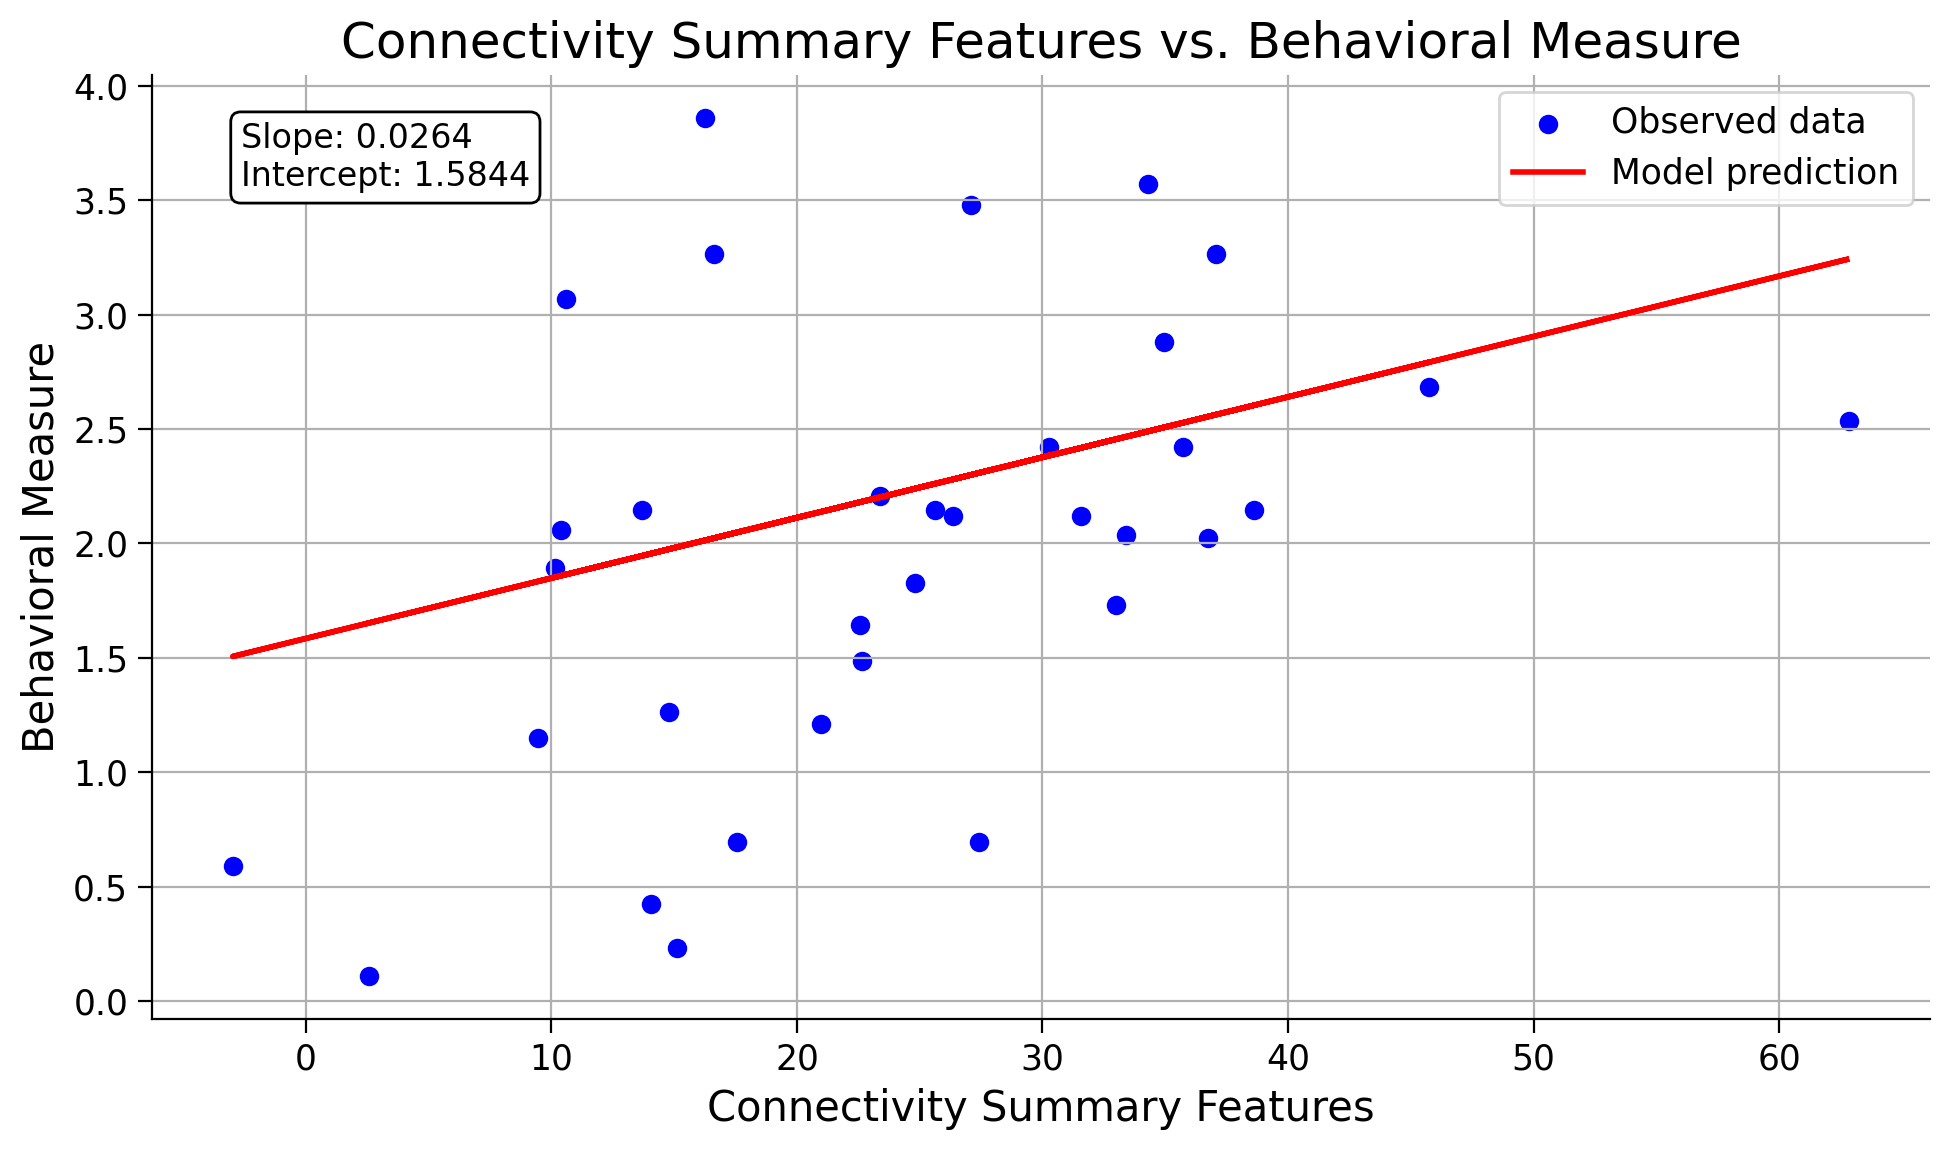

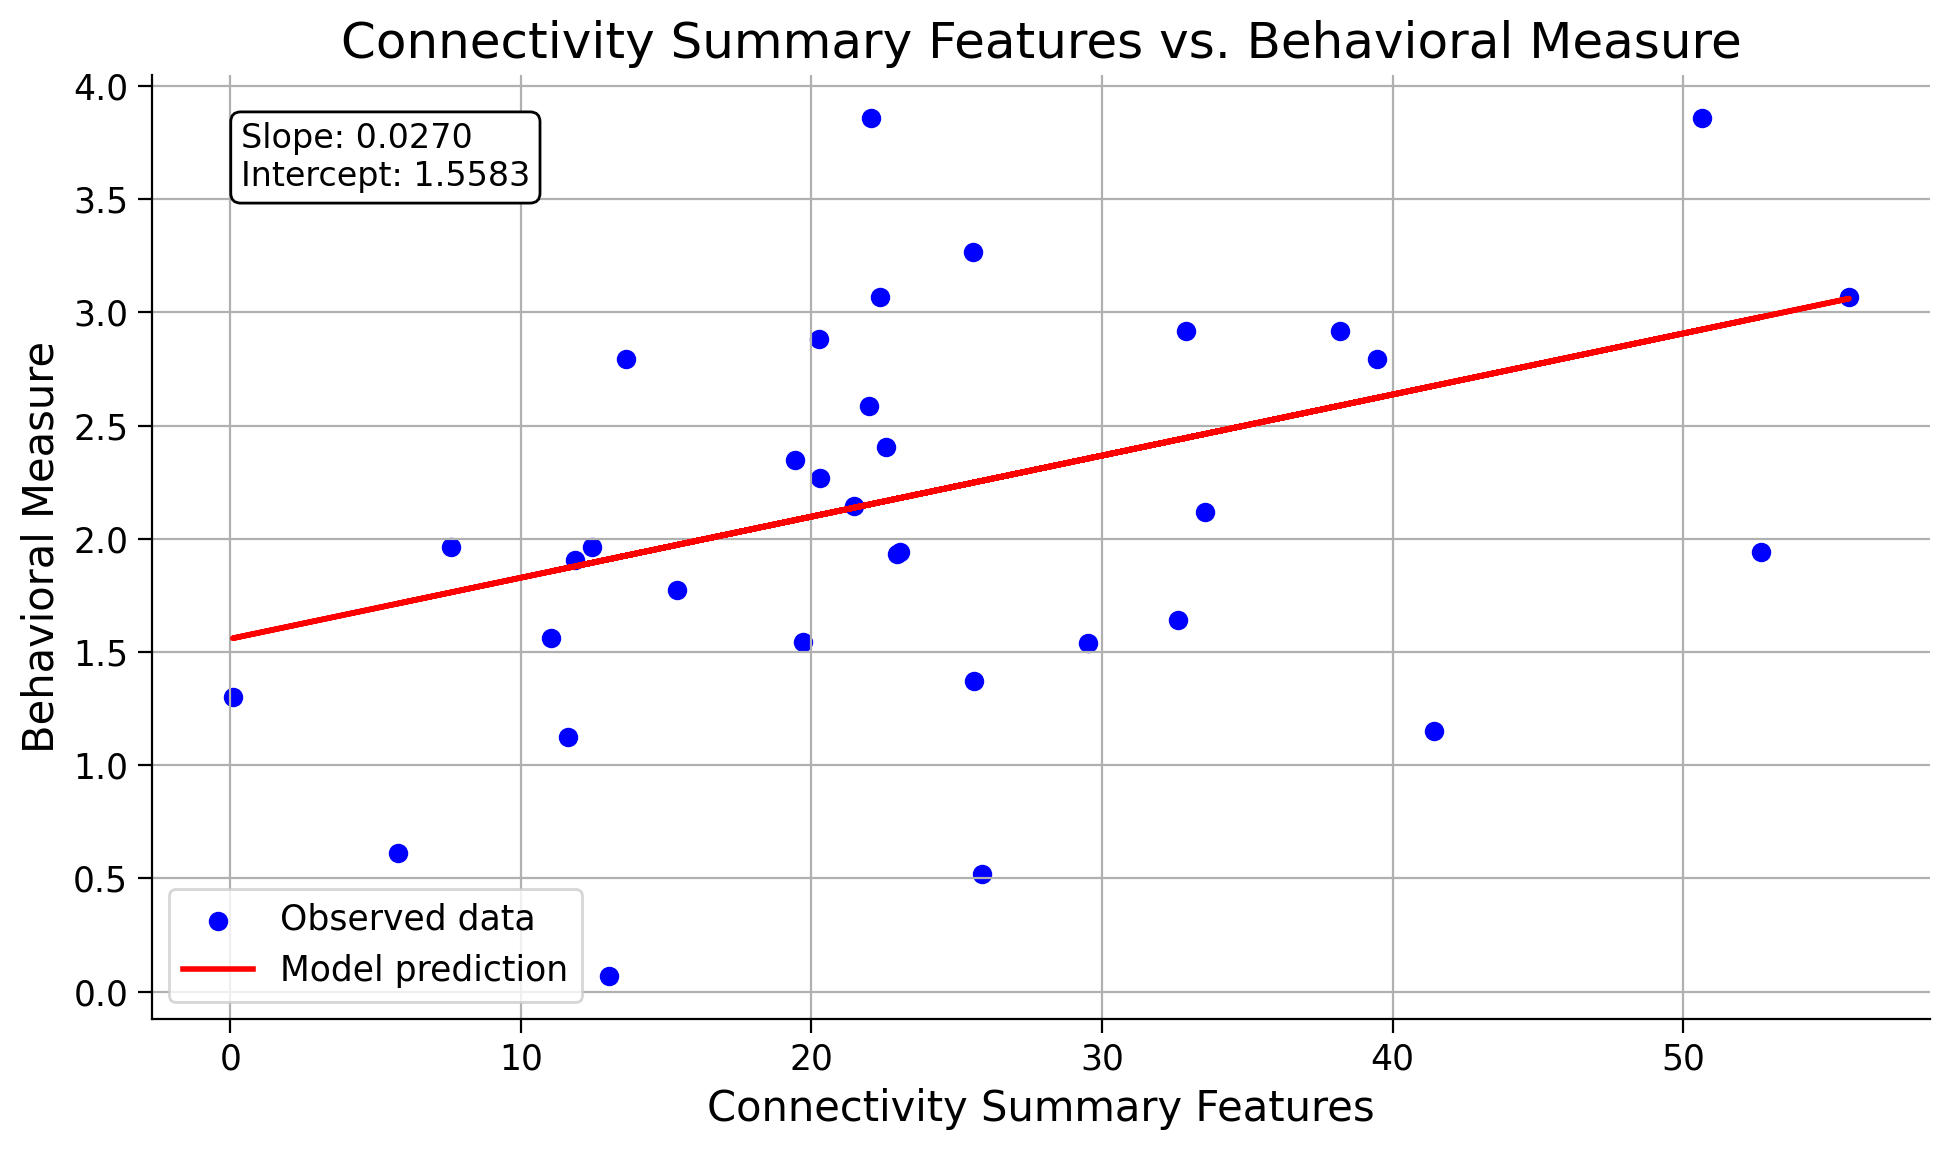

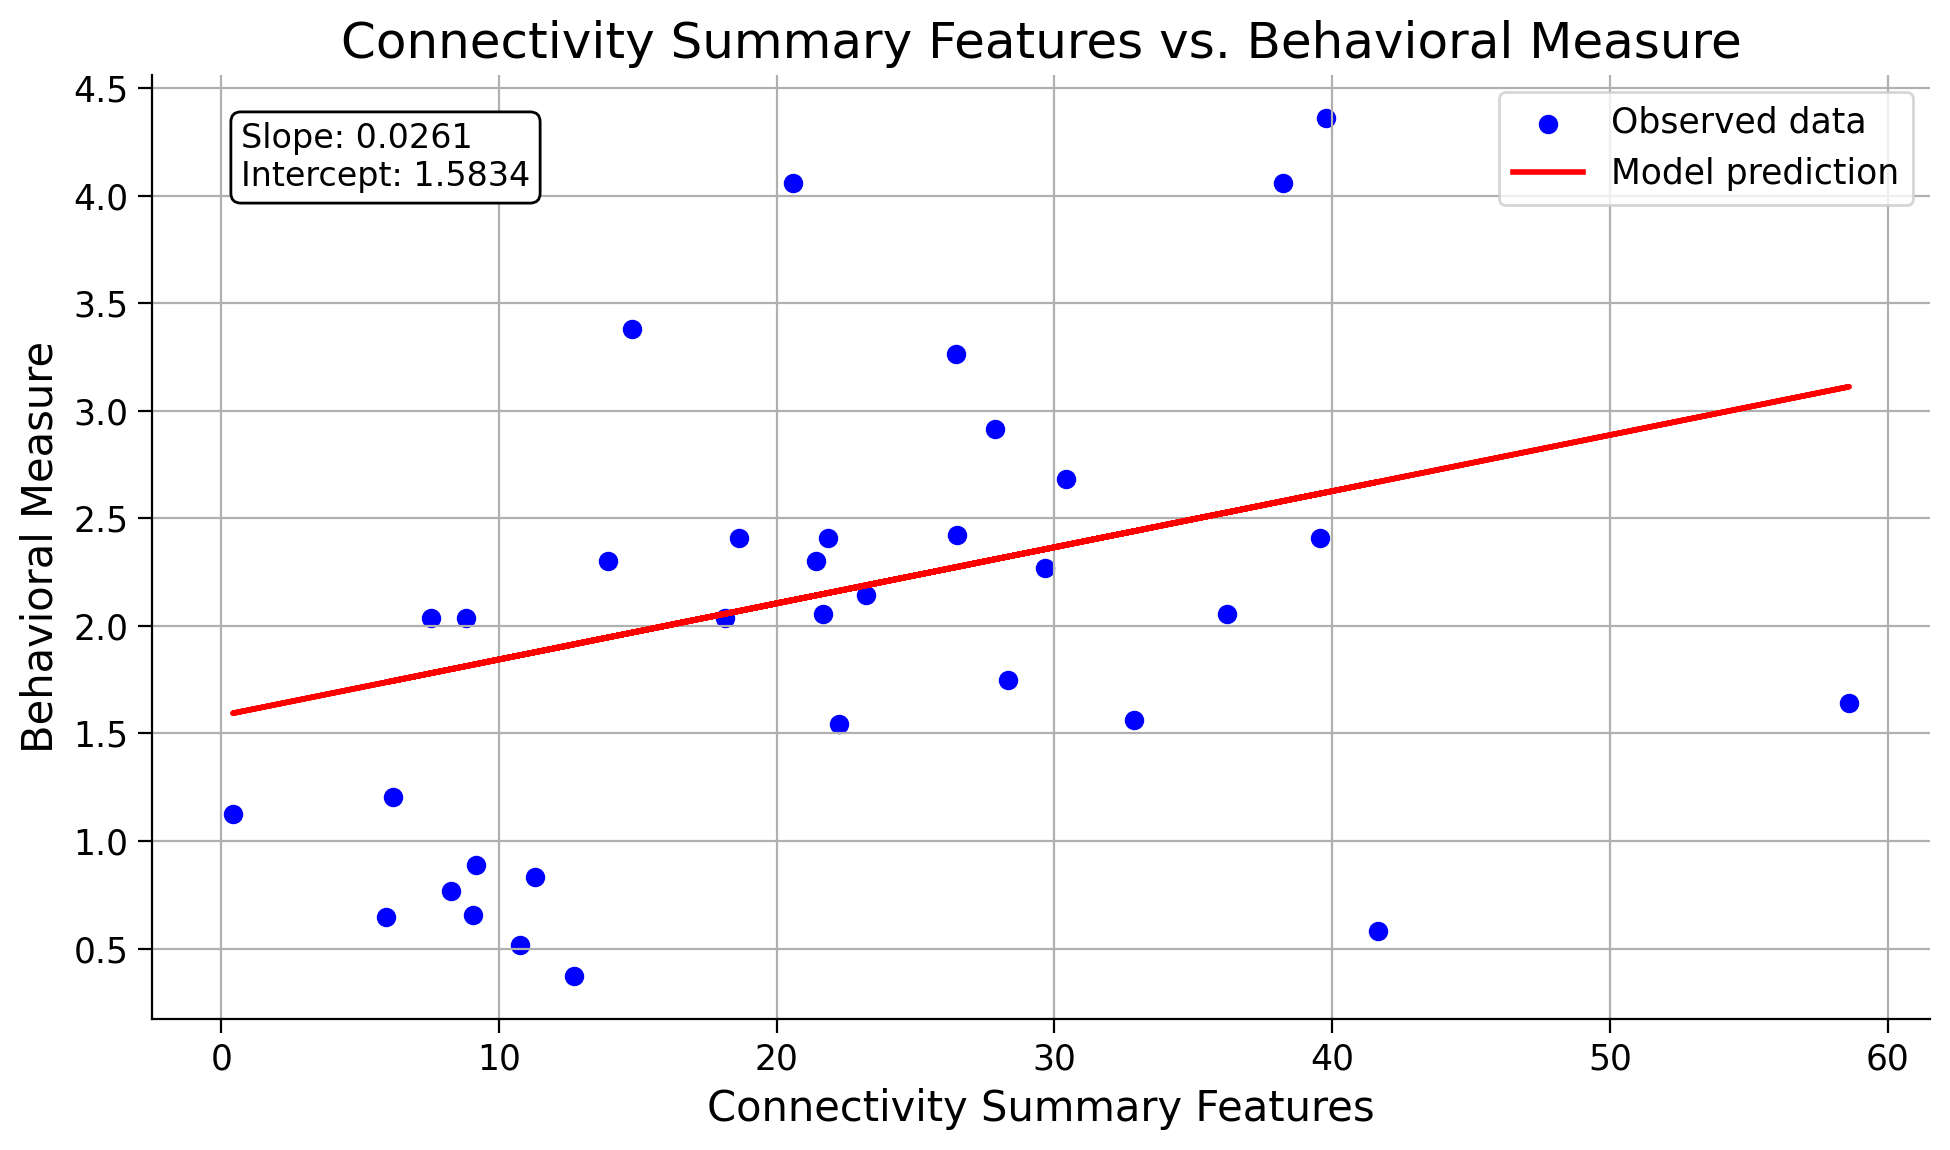

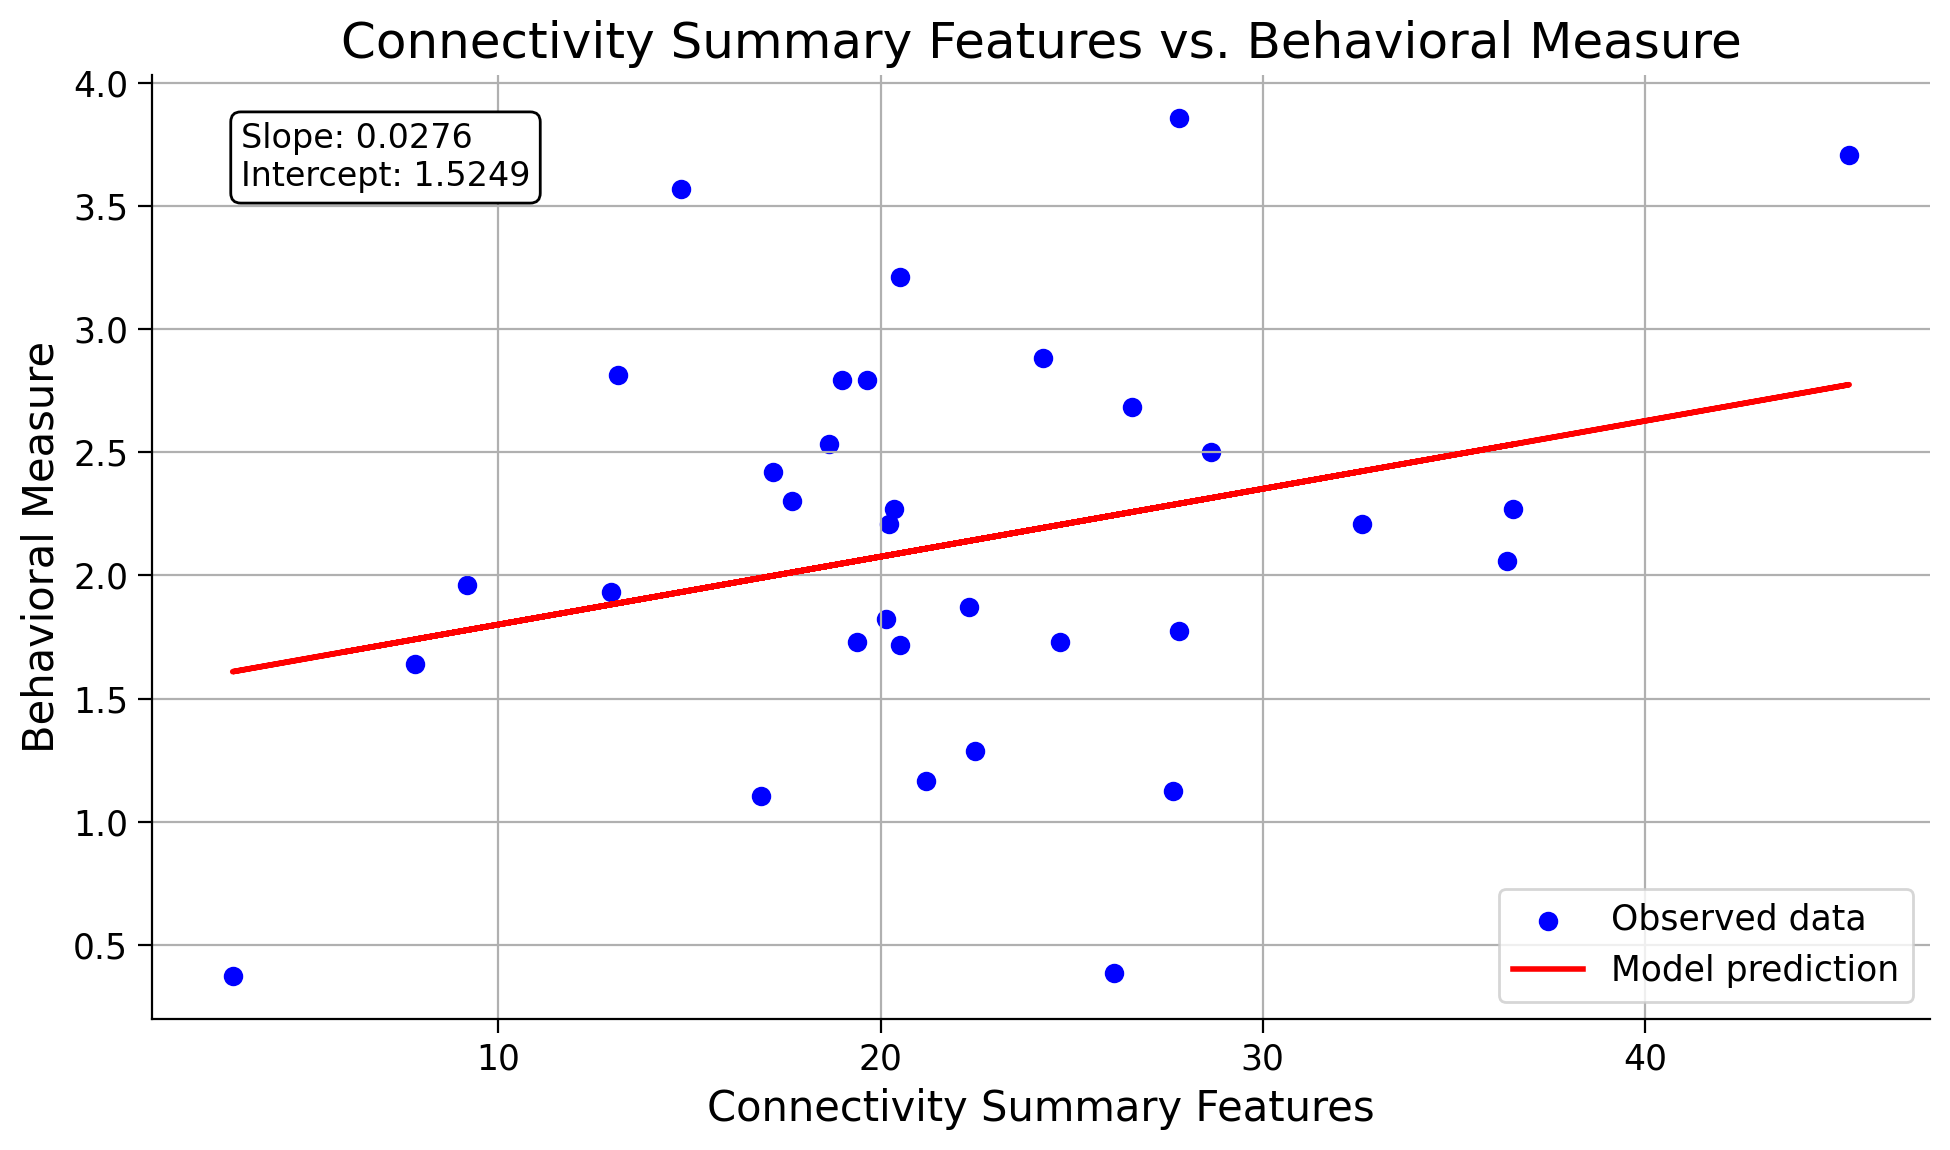

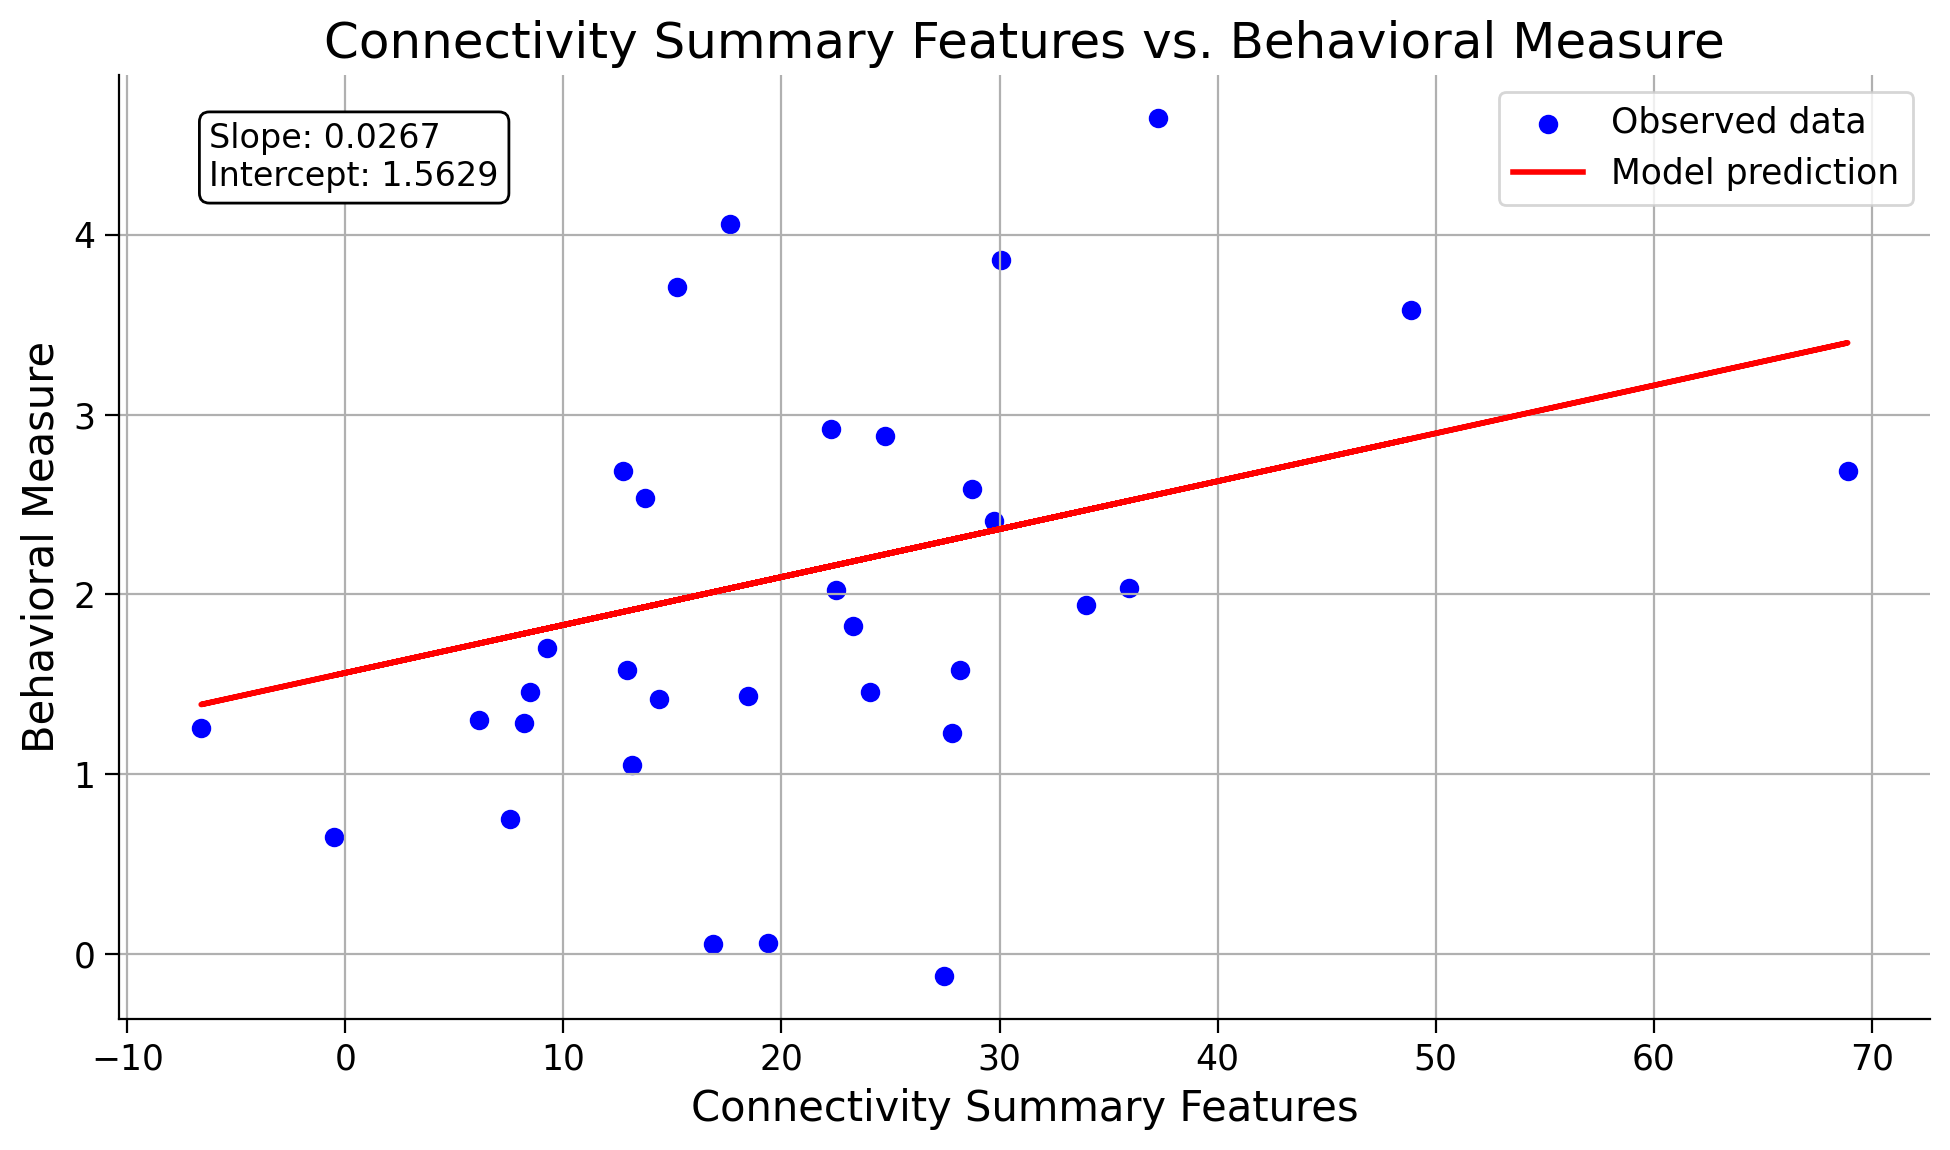

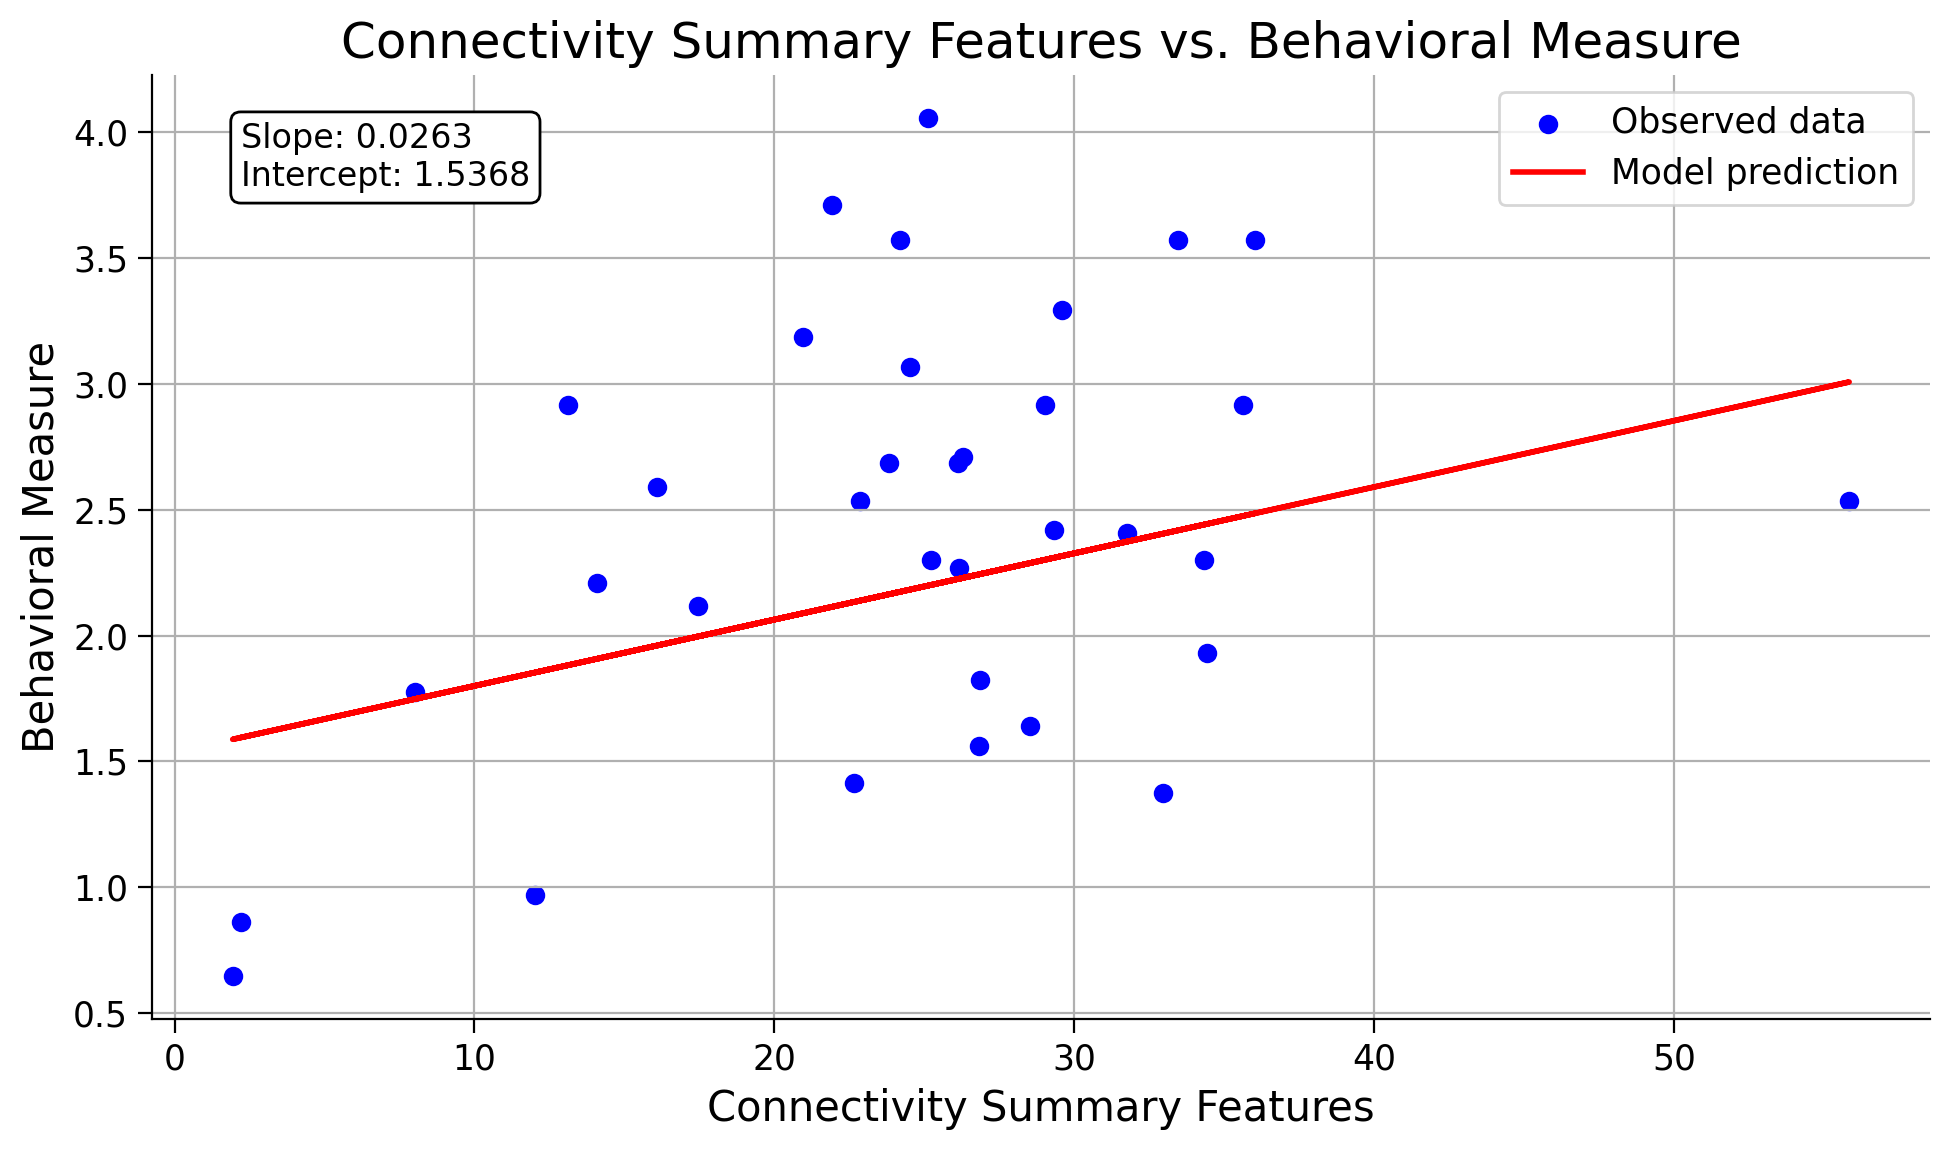

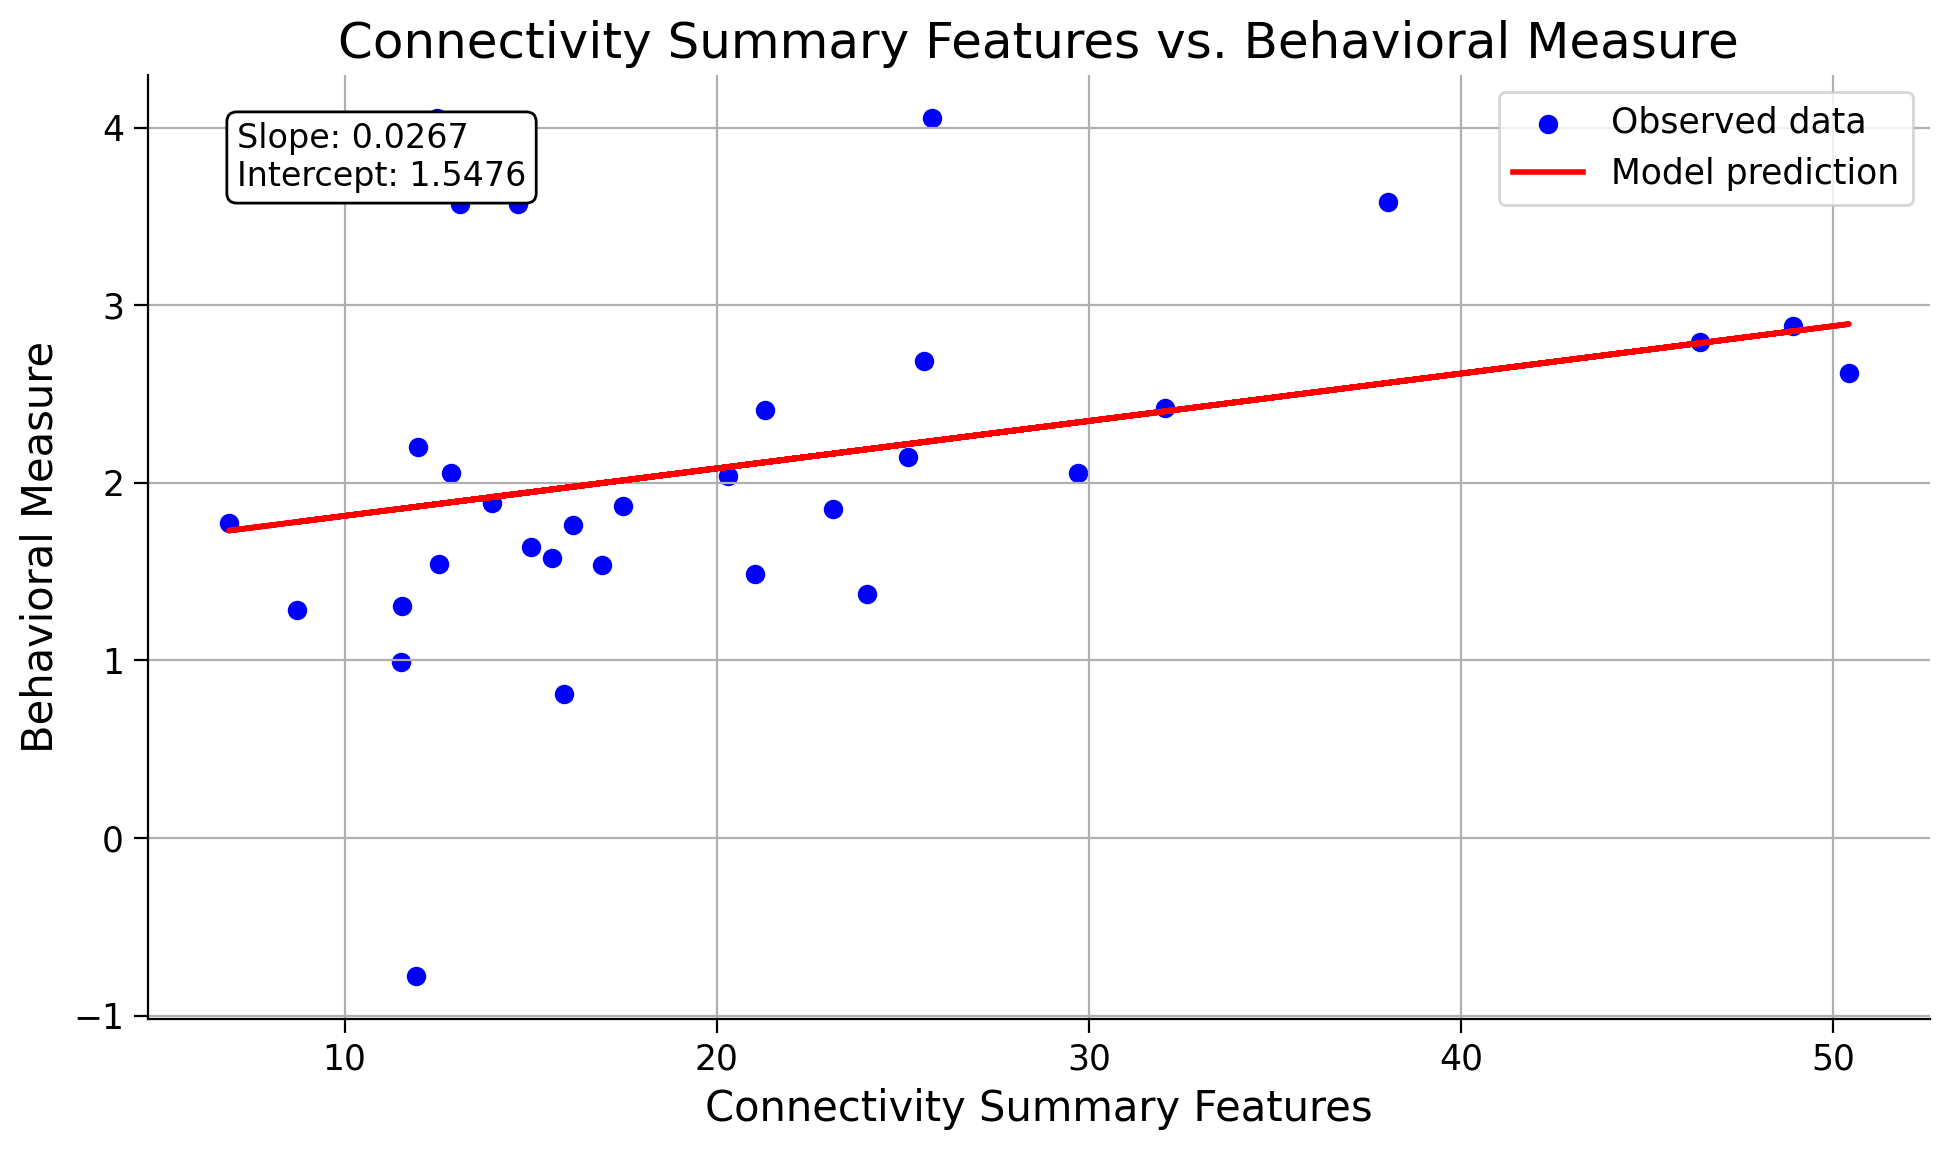

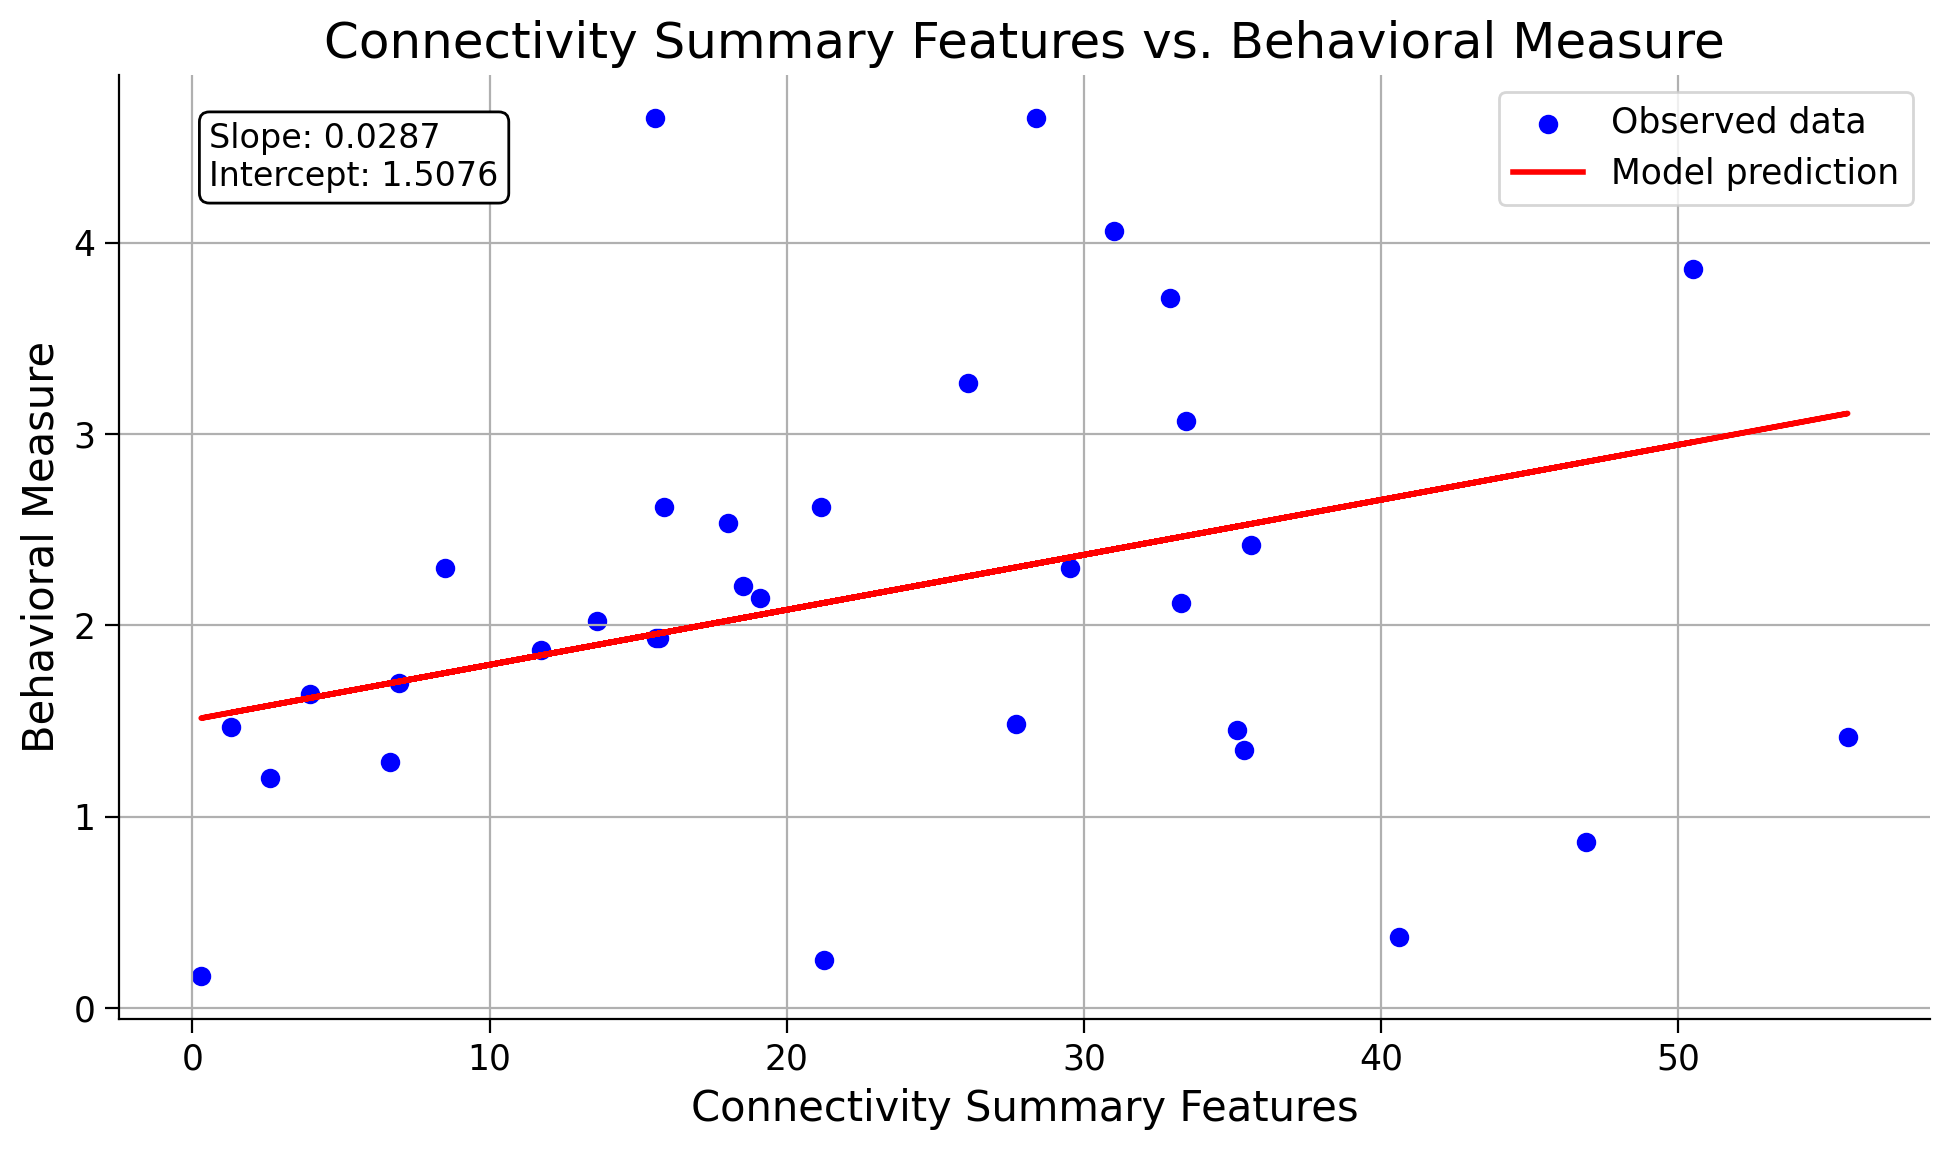

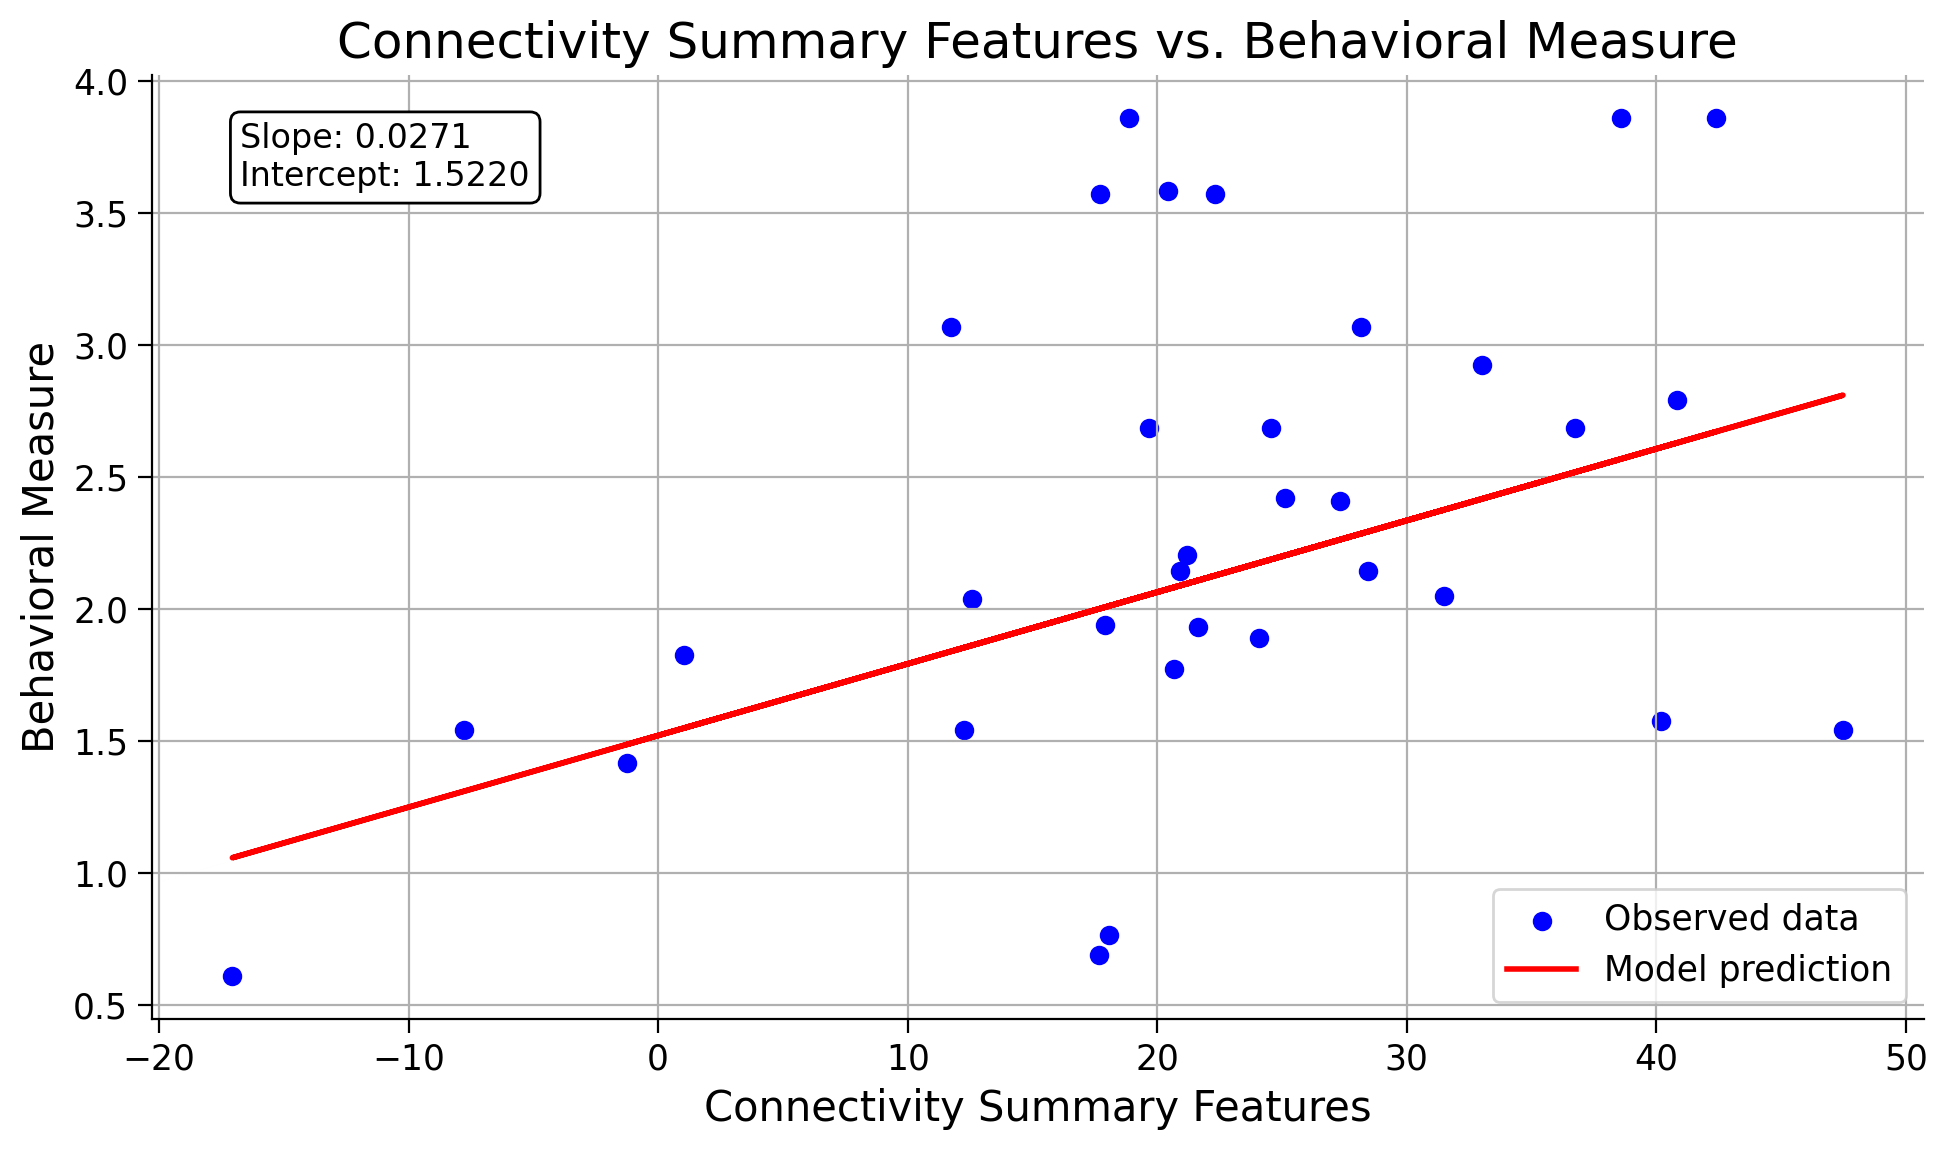

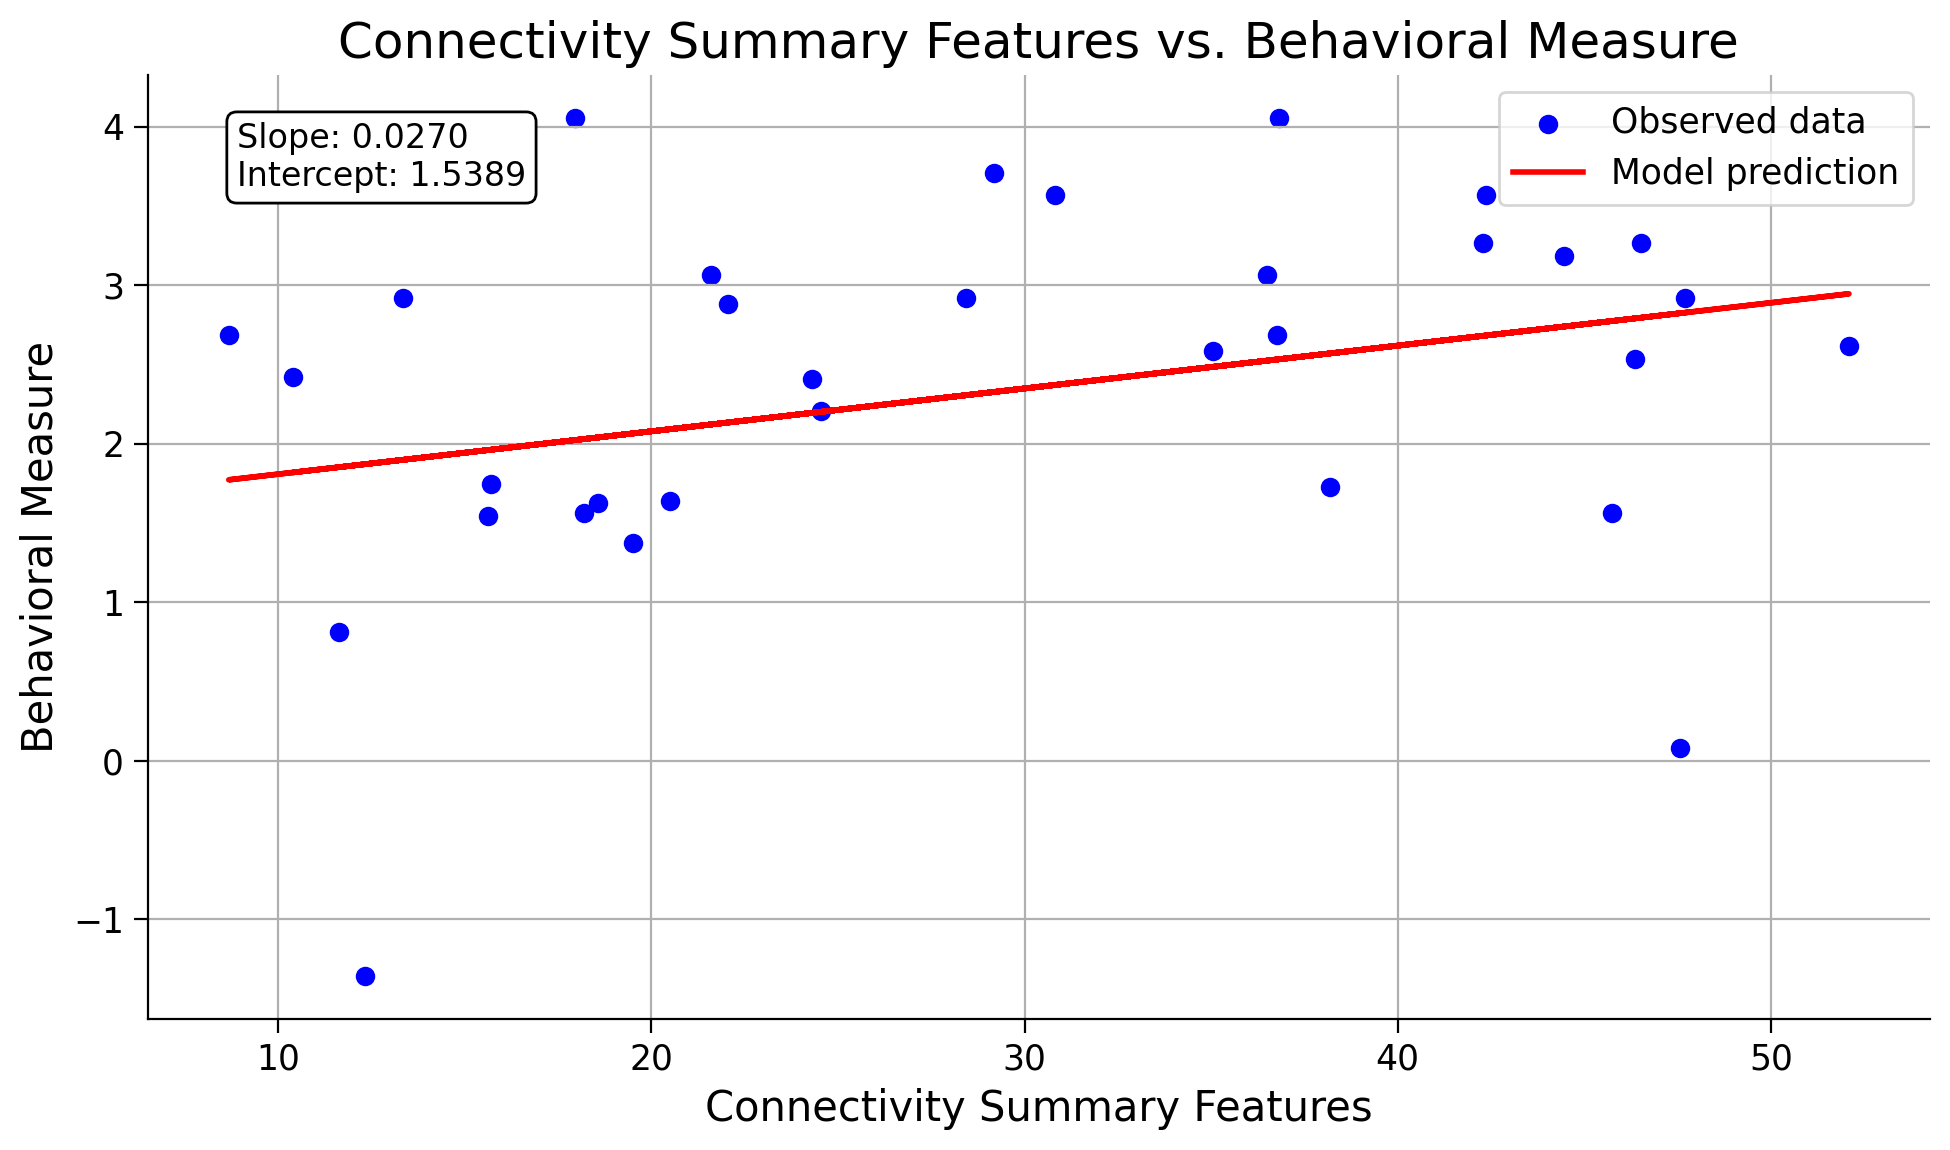

KFOLD Mean R score across 10 folds: 0.2733
KFOLD Mean p-values across 10 folds: 1.9463E-09
KFOLD Mean MSE score across 10 folds: 0.9094
BOOTSTRAP Mean R score across 500 run: 0.2993
BOOTSTRAP Mean p-values across 500 run: 4.1172E-05
BOOTSTRAP Mean MSE score across 500 run: 0.9205


In [111]:
positive_kfold_result = kfold_cross_validation(X_summary_positive.reshape(-1, 1), y, plotting=True)
print(f"KFOLD Mean R score across 10 folds: {positive_kfold_result[0]:.4f}")
print(f"KFOLD Mean p-values across 10 folds: {positive_kfold_result[2][0]:.4E}")
print(f"KFOLD Mean MSE score across 10 folds: {positive_kfold_result[1]:.4f}")

positive_bootstrap_result = bootstrapping_validation(X_summary_positive.reshape(-1, 1), y, plotting=False)
print(f"BOOTSTRAP Mean R score across 500 run: {positive_bootstrap_result[0]:.4f}")
print(f"BOOTSTRAP Mean p-values across 500 run: {positive_bootstrap_result[2][0]:.4E}")
print(f"BOOTSTRAP Mean MSE score across 500 run: {positive_bootstrap_result[1]:.4f}")

In [110]:
negative_kfold_result = kfold_cross_validation(X_summary_negative.reshape(-1, 1), y, plotting=False)
print(f"KFOLD Mean R score across 10 folds: {negative_kfold_result[0]:.4f}")
print(f"KFOLD Mean p-values across 10 folds: {negative_kfold_result[2][0]:.4E}")
print(f"KFOLD Mean MSE score across 10 folds: {negative_kfold_result[1]:.4f}")

negative_bootstrap_result = bootstrapping_validation(X_summary_negative.reshape(-1, 1), y, plotting=False)
print(f"BOOTSTRAP Mean R score across 500 run: {negative_bootstrap_result[0]:.4f}")
print(f"BOOTSTRAP Mean p-values across 500 run: {negative_bootstrap_result[2][0]:.4E}")
print(f"BOOTSTRAP Mean MSE score across 500 run: {negative_bootstrap_result[1]:.4f}")

KFOLD Mean R score across 10 folds: 0.2066
KFOLD Mean p-values across 10 folds: 2.4425E-08
KFOLD Mean MSE score across 10 folds: 0.9255
BOOTSTRAP Mean R score across 500 run: 0.2808
BOOTSTRAP Mean p-values across 500 run: 7.3484E-05
BOOTSTRAP Mean MSE score across 500 run: 0.9293
